In [1]:
import snowflake.connector
import sys
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 100

In [3]:
plt.rcParams["figure.figsize"] = (10,8)
plt.style.use('seaborn-darkgrid')

In [4]:
con = snowflake.connector.connect(
    user="tliang@endpointclosing.com",
    account="endpoint",
    authenticator="externalbrowser",
    role="SNOWFLAKE_DATA_ENGINEERING",
    warehouse="DATAENGINEERING_WH"
)
cur = con.cursor()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [5]:
query = "SELECT * FROM LAKE.SALESFORCE.LEAD"
lead = cur.execute(query).fetch_pandas_all().reset_index()

In [6]:
# lead[lead['IS_DELETED'] == False]

In [7]:
states = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AS': 'American Samoa',#
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'GU': 'Guam',#
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MP': 'Northern Mariana Islands',#
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'PR': 'Puerto Rico',#
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VI': 'Virgin Islands',#
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}

def state_std(x:str):

    if x is None:
        return ""

    elif (len(x) == 2) & (x.isalpha()):
        return x.upper()
    else:
        for key, value in states.items():
            if x.lower() == value.lower():
                return key
        return ""


In [8]:
lead["STATE_STD"] = lead["STATE"].apply(state_std)

In [9]:
# check the prop of NAs and flag each column
for col in lead.columns:
    num_empty = lead[col].isnull().sum()
    prop = num_empty / len(lead)
    print("{} Column: {:20} -- % Missing: {:.4f}".format("!" if prop > 0.3 else "",col,prop)) # try to align the dash to make the number aligned

 Column: index                -- % Missing: 0.0000
 Column: ID                   -- % Missing: 0.0000
 Column: IS_DELETED           -- % Missing: 0.0000
! Column: MASTER_RECORD_ID     -- % Missing: 0.9996
 Column: LAST_NAME            -- % Missing: 0.0000
 Column: FIRST_NAME           -- % Missing: 0.0003
! Column: SALUTATION           -- % Missing: 0.9991
! Column: MIDDLE_NAME          -- % Missing: 0.4921
! Column: SUFFIX               -- % Missing: 1.0000
 Column: NAME                 -- % Missing: 0.0000
 Column: RECORD_TYPE_ID       -- % Missing: 0.0009
! Column: TITLE                -- % Missing: 0.9992
! Column: COMPANY              -- % Missing: 0.3747
 Column: STREET               -- % Missing: 0.0084
 Column: CITY                 -- % Missing: 0.0247
 Column: STATE                -- % Missing: 0.0062
 Column: POSTAL_CODE          -- % Missing: 0.0253
! Column: COUNTRY              -- % Missing: 0.9998
! Column: LATITUDE             -- % Missing: 0.9999
! Column: LONGITUDE    

### Washington Market 

In [10]:
lead.groupby("STATE_STD")["STATUS"].value_counts()

STATE_STD  STATUS      
           New               4150
           Disqualified       418
           Working            202
           Committed          133
AK         New                  3
AL         New                  2
AR         New                  3
AZ         New              56403
           Disqualified      1773
           Working           1553
           Committed         1257
CA         New             188131
           Committed         2939
           Disqualified      2350
           Working           1616
CO         New                406
           Committed            4
           Disqualified         1
CT         New                  4
DC         New                  3
DE         New                  1
FL         New             264950
           Committed           16
           Working              8
           Disqualified         6
GA         New                 29
           Committed            7
HI         New                 19
           Committed    

In [11]:
lead[(lead["IS_DELETED"] == False)]["STATUS"].value_counts()

New             479575
Committed         8818
Disqualified      7674
Working           4269
Name: STATUS, dtype: int64

In [12]:
wa_lead = lead[(lead["IS_DELETED"] == False)& (lead["STATE_STD"] == "WA")& (lead["STATUS"]!= "New")]

In [13]:
wa_lead.to_csv("wa_lead.csv")

In [14]:
wa_lead["STATUS"].value_counts()

Committed       3717
Disqualified    2792
Working          407
Name: STATUS, dtype: int64

In [15]:
wa_lead[wa_lead["CONVERTED_CONTACT_ID"].notnull()]["STATUS"].value_counts()

Committed       3640
Disqualified     417
Name: STATUS, dtype: int64

In [16]:
wa_lead[wa_lead["STATUS"] == 'Committed']["APEX_PROCESSED_C"].value_counts()

False    2107
True     1610
Name: APEX_PROCESSED_C, dtype: int64

In [17]:
wa_lead["LEVEL_VETTING_C"].value_counts()

Level 2 - 4+ listings/yr             2090
Level 3 - Less than 4 listings/yr    1893
Level 1 - 10+ listings/yr            1878
Level Platinum 30+ Listings/yr         50
Level Gold 20-29 Listings/yr           46
Name: LEVEL_VETTING_C, dtype: int64

In [18]:
wa_lead[wa_lead["STATUS"] != "New"].groupby("LEVEL_VETTING_C")["STATUS"].value_counts()

LEVEL_VETTING_C                    STATUS      
Level 1 - 10+ listings/yr          Disqualified    1010
                                   Committed        780
                                   Working           88
Level 2 - 4+ listings/yr           Committed       1030
                                   Disqualified     955
                                   Working          105
Level 3 - Less than 4 listings/yr  Committed       1195
                                   Disqualified     561
                                   Working          137
Level Gold 20-29 Listings/yr       Disqualified      32
                                   Working            9
                                   Committed          5
Level Platinum 30+ Listings/yr     Disqualified      33
                                   Working           15
                                   Committed          2
Name: STATUS, dtype: int64

In [19]:
wa_lead.columns.to_list()

['index',
 'ID',
 'IS_DELETED',
 'MASTER_RECORD_ID',
 'LAST_NAME',
 'FIRST_NAME',
 'SALUTATION',
 'MIDDLE_NAME',
 'SUFFIX',
 'NAME',
 'RECORD_TYPE_ID',
 'TITLE',
 'COMPANY',
 'STREET',
 'CITY',
 'STATE',
 'POSTAL_CODE',
 'COUNTRY',
 'LATITUDE',
 'LONGITUDE',
 'GEOCODE_ACCURACY',
 'PHONE',
 'MOBILE_PHONE',
 'FAX',
 'EMAIL',
 'WEBSITE',
 'PHOTO_URL',
 'DESCRIPTION',
 'LEAD_SOURCE',
 'STATUS',
 'INDUSTRY',
 'RATING',
 'ANNUAL_REVENUE',
 'NUMBER_OF_EMPLOYEES',
 'OWNER_ID',
 'HAS_OPTED_OUT_OF_EMAIL',
 'IS_CONVERTED',
 'CONVERTED_DATE',
 'CONVERTED_ACCOUNT_ID',
 'CONVERTED_CONTACT_ID',
 'CONVERTED_OPPORTUNITY_ID',
 'IS_UNREAD_BY_OWNER',
 'CREATED_DATE',
 'CREATED_BY_ID',
 'LAST_MODIFIED_DATE',
 'LAST_MODIFIED_BY_ID',
 'SYSTEM_MODSTAMP',
 'LAST_ACTIVITY_DATE',
 'DO_NOT_CALL',
 'HAS_OPTED_OUT_OF_FAX',
 'LAST_VIEWED_DATE',
 'LAST_REFERENCED_DATE',
 'LAST_TRANSFER_DATE',
 'JIGSAW',
 'JIGSAW_CONTACT_ID',
 'EMAIL_BOUNCED_REASON',
 'EMAIL_BOUNCED_DATE',
 'INDIVIDUAL_ID',
 'POSTAL_CODE_C',
 'MOST_RE

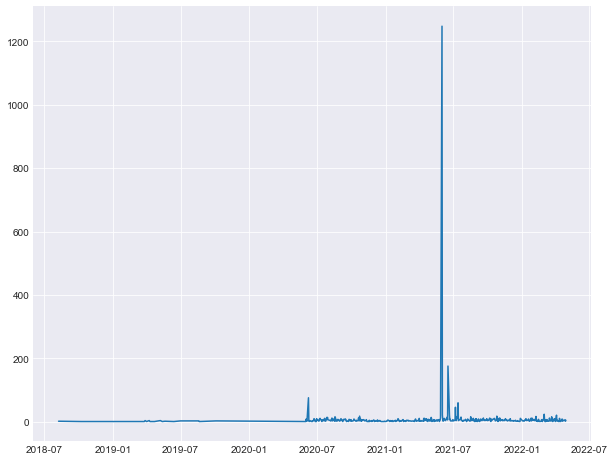

In [20]:
wa_lead["CONVERTED_DATE"].value_counts().plot()
plt.show()

In [21]:
wa_lead.groupby("APEX_PROCESSED_C")["STATUS"].value_counts()

APEX_PROCESSED_C  STATUS      
False             Disqualified    2398
                  Committed       2107
                  Working          407
True              Committed       1610
                  Disqualified     394
Name: STATUS, dtype: int64

#### Lead History

In [22]:
# list history
query = "SELECT * FROM LAKE.SALESFORCE.LEAD_HISTORY"
lead_hist = cur.execute(query).fetch_pandas_all().reset_index()

In [23]:
wa_lead_hist = lead_hist[(lead_hist["LEAD_ID"].isin(wa_lead["ID"])) & (lead_hist["IS_DELETED"] == False)]

In [234]:
wa_lead_hist_cutoff = wa_lead_hist[(wa_lead_hist["CREATED_DATE"].dt.date >= dt.date(2021,6,1))& (wa_lead_hist["CREATED_DATE"].dt.date < dt.date(2021,12,1))]

In [235]:
# wa_lead_hist_cutoff.to_csv("wa_lead_hist_cutoff.csv")

In [231]:
cutoff_date_start

datetime.date(2021, 6, 1)

In [24]:
wa_lead_hist["LEAD_ID"].nunique()

6734

In [25]:
wa_lead_hist.head(10)

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
28,28,0171H00014unkH2QAI,False,00Q1H00001FdFOEUA3,0051H00000BeVAmQAN,2021-09-13 20:06:22-07:00,Status,DynamicEnum,New,Committed,2021-09-14 01:43:04.689000-07:00
30,30,0171H00014unkFkQAI,False,00Q1H00001Ewg9KUAR,0051H00000BeVAmQAN,2021-09-13 20:06:10-07:00,Status,DynamicEnum,New,Committed,2021-09-14 01:43:04.689000-07:00
31,31,0171H00014unk9dQAA,False,00Q1H00001FdEyBUAV,0051H00000BeVAmQAN,2021-09-13 20:04:58-07:00,Owner,Text,Erica Dinsmore,Unassigned Lead,2021-09-14 01:43:04.689000-07:00
33,33,0171H00014unk8PQAQ,False,00Q1H00001FdFh6UAF,0051H00000BeVAmQAN,2021-09-13 20:04:36-07:00,leadConverted,Text,None,None,2021-09-14 01:43:04.689000-07:00
34,34,0171H00014unk6pQAA,False,00Q1H00001FdHlMUAV,0051H00000BeVAmQAN,2021-09-13 20:04:27-07:00,Status,DynamicEnum,New,Committed,2021-09-14 01:43:04.689000-07:00
35,35,0171H00014unk9aQAA,False,00Q1H00001FdEyBUAV,0051H00000BeVAmQAN,2021-09-13 20:04:58-07:00,Status,DynamicEnum,New,Committed,2021-09-14 01:43:04.689000-07:00
36,36,0171H00014unk73QAA,False,00Q1H00001FdHlMUAV,0051H00000BeVAmQAN,2021-09-13 20:04:27-07:00,Owner,EntityId,0051H00000AeGKuQAN,00G1H000004ldrdUAA,2021-09-14 01:43:04.689000-07:00
37,37,0171H00014unkH4QAI,False,00Q1H00001FdFOEUA3,0051H00000BeVAmQAN,2021-09-13 20:06:22-07:00,Owner,EntityId,00G1H000004ldrdUAA,0051H00000AeGKuQAN,2021-09-14 01:43:04.689000-07:00
38,38,0171H00014unkAkQAI,False,00Q1H00001Ewg9KUAR,0051H00000BeVAmQAN,2021-09-13 20:06:10-07:00,leadConverted,Text,None,None,2021-09-14 01:43:04.689000-07:00
40,40,0171H00014unkH5QAI,False,00Q1H00001FdFOEUA3,0051H00000BeVAmQAN,2021-09-13 20:06:22-07:00,Owner,Text,Amanda Bell,Unassigned Lead,2021-09-14 01:43:04.689000-07:00


In [26]:
# wa_lead_hist.dtypes

In [27]:
# sample lead for all status history
wa_lead_hist[(wa_lead_hist["LEAD_ID"] == '00Q1H00001CsLjeUAF') & (wa_lead_hist["FIELD"] == 'Status')].sort_values(by = "CREATED_DATE")

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
1019356,19133,0171H0000x49h0oQAA,False,00Q1H00001CsLjeUAF,0051H00000A36H7QAJ,2020-05-28 13:32:11-07:00,Status,DynamicEnum,Disqualified,Working,2021-09-07 17:03:15.928000-07:00
151211,42849,0171H0000x49hZ1QAI,False,00Q1H00001CsLjeUAF,0051H00000A36H7QAJ,2020-05-28 13:36:44-07:00,Status,DynamicEnum,Working,New,2021-09-07 17:03:15.925000-07:00
1067232,12047,0171H0000xdiOt5QAE,False,00Q1H00001CsLjeUAF,0051H000008rwTGQAY,2020-06-29 22:42:02-07:00,Status,DynamicEnum,New,Disqualified,2021-09-07 17:03:04.260000-07:00
280173,71382,0171H0000xhm7mUQAQ,False,00Q1H00001CsLjeUAF,0051H000008rwTGQAY,2020-07-02 11:58:13-07:00,Status,DynamicEnum,Disqualified,New,2021-09-07 17:03:03.992000-07:00
295871,87080,0171H0000zAoZ0GQAV,False,00Q1H00001CsLjeUAF,0051H000008sMEFQA2,2020-09-18 12:59:43-07:00,Status,DynamicEnum,New,Working,2021-09-07 17:03:03.682000-07:00
107537,53870,0171H0000zFbx0SQAR,False,00Q1H00001CsLjeUAF,0051H000008sMEFQA2,2020-09-22 10:22:56-07:00,Status,DynamicEnum,Working,Disqualified,2021-09-07 17:03:03.682000-07:00
1461446,105437,0171H00014A8Rh0QAF,False,00Q1H00001CsLjeUAF,0051H000008sMEFQA2,2021-07-13 10:06:58-07:00,Status,DynamicEnum,Working,Disqualified,2021-09-07 17:03:01.627000-07:00
1467096,111087,0171H00014A8RgyQAF,False,00Q1H00001CsLjeUAF,0051H000008sMEFQA2,2021-07-13 10:06:58-07:00,Status,DynamicEnum,Disqualified,Working,2021-09-07 17:03:01.627000-07:00
1024084,23861,0171H00014A8ZLqQAN,False,00Q1H00001CsLjeUAF,0051H000008sMEFQA2,2021-07-13 10:33:24-07:00,Status,DynamicEnum,Working,Disqualified,2021-09-07 17:03:01.627000-07:00
2434691,79087,0171H00014A8ZLpQAN,False,00Q1H00001CsLjeUAF,0051H000008sMEFQA2,2021-07-13 10:33:24-07:00,Status,DynamicEnum,Disqualified,Working,2021-09-07 17:03:01.627000-07:00


In [28]:
wa_lead_hist['FIELD'].unique()

array(['Status', 'Owner', 'leadConverted', 'Level_Vetting__c',
       'LeadSource', 'Last_Modified__c', 'MobilePhone', 'Email',
       'Disqualified_Reasons__c', 'Brokerage1__c', 'created', 'Phone',
       'Preferred_Title_Company__c', 'Role__c', 'License_No__c',
       'leadMerged', 'Total_Listing_Count__c',
       'Preferred_Escrow_Company__c', 'Total_Transaction_Count__c',
       'FA_Loyal_Lead__c', 'ownerAssignment', 'Disqualified_Notes__c',
       'App_Download_Date__c', 'Product_Demo_Date__c',
       'Average_Close_Price__c', 'Relationship_Manager__c'], dtype=object)

In [29]:
wa_lead_hist.sort_values(by = ["LEAD_ID","CREATED_DATE"])

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
308764,99973,0171H0000zECAy3QAH,False,00Q1H000013ysKgUAI,0051H00000A36H7QAJ,2020-09-21 09:33:58-07:00,Owner,EntityId,0051H000008zRJ4QAM,0051H00000A36H7QAJ,2021-09-07 17:02:58.680000-07:00
1356351,342,0171H0000zECAy2QAH,False,00Q1H000013ysKgUAI,0051H00000A36H7QAJ,2020-09-21 09:33:58-07:00,Owner,Text,Garreth Long,John Kirkpatrick,2021-09-07 17:02:58.680000-07:00
1356620,611,0171H0000zECAy4QAH,False,00Q1H000013ysKgUAI,0051H00000A36H7QAJ,2020-09-21 09:33:58-07:00,Last_Modified__c,DateOnly,None,2020-09-21,2021-09-07 17:03:48.546000-07:00
520066,110966,0171H00010Ps0LuQAJ,False,00Q1H000013ysKgUAI,0051H00000A36H7QAJ,2020-11-18 11:48:29-08:00,Last_Modified__c,DateOnly,2020-09-21,2020-11-18,2021-09-07 17:03:48.169000-07:00
13761,2516,0178V00016W9c0WQAR,False,00Q1H000013ysKgUAI,0051H000008zRJ4QAM,2022-01-10 07:03:14-08:00,Owner,EntityId,0051H00000A36H7QAJ,0051H000008sMEFQA2,2022-01-10 12:41:31.483000-08:00
...,...,...,...,...,...,...,...,...,...,...,...
2477429,20951,0178V00018EF2TlQAL,False,00Q8V00001Na7P0UAJ,0058V00000C7vbmQAB,2022-04-22 18:12:46-07:00,Status,DynamicEnum,New,Committed,2022-04-22 19:40:57.386000-07:00
2477441,20963,0178V00018EF2TgQAL,False,00Q8V00001Na7P0UAJ,0058V00000C7vbmQAB,2022-04-22 18:12:47-07:00,leadConverted,Text,None,None,2022-04-22 19:40:57.386000-07:00
2475153,18675,0178V00018Hb1uEQAR,False,00Q8V00001NaWWIUA3,0058V00000C7zXLQAZ,2022-04-27 10:27:39-07:00,created,Text,None,None,2022-04-27 11:40:57.562000-07:00
2475099,18621,0178V00018Hb9tlQAB,False,00Q8V00001NaWWIUA3,0058V00000C7zXLQAZ,2022-04-27 10:31:58-07:00,Status,DynamicEnum,Working,Committed,2022-04-27 11:40:57.563000-07:00


In [30]:
wa_lead_hist_status = wa_lead_hist[["LEAD_ID","CREATED_DATE","FIELD","OLD_VALUE","NEW_VALUE"]].query("FIELD == 'Status'")

In [31]:
wa_lead_hist_status["VALUE_AGG"] = wa_lead_hist_status["OLD_VALUE"] + "-" + wa_lead_hist_status["NEW_VALUE"]


In [32]:
wa_lead_hist_status = wa_lead_hist_status.sort_values(by = ["LEAD_ID","CREATED_DATE"])

In [33]:
wa_lead_hist_status_agg = wa_lead_hist_status.groupby("LEAD_ID")["VALUE_AGG"].agg(",".join).reset_index()

In [34]:
wa_lead_hist_status_agg

,LEAD_ID,VALUE_AGG
0,00Q1H000013ysKnUAI,"Committed-Disqualified,Disqualified-Committed,..."
1,00Q1H000013ysKpUAI,Working-Disqualified
2,00Q1H000014wKDTUA2,Working-Committed
3,00Q1H000014wKDVUA2,"Working-Disqualified,Disqualified-Working,Disq..."
4,00Q1H000014xQRqUAM,Working-Committed
...,...,...
6441,00Q8V00001NKFnbUAH,New-Committed
6442,00Q8V00001NKLRDUA5,New-Committed
6443,00Q8V00001NZsCcUAL,Working-Committed
6444,00Q8V00001Na7P0UAJ,New-Committed


In [35]:
wa_lead_hist_status_agg["VALUE_AGG_CLEAN"] = wa_lead_hist_status_agg["VALUE_AGG"].apply(lambda x: ",".join([i if "," not in i else i.split(",")[0]for i in x.split("-")]))

In [36]:
wa_lead_hist_status_agg["VALUE_AGG_CLEAN"].value_counts().to_frame().head(20)

,VALUE_AGG_CLEAN
"New,Working,New,Committed",1699
"New,Working,New,Disqualified",1307
"New,Working,New,Working,Committed",378
"New,Committed",356
"New,Working,New,Disqualified,New,Disqualified",332
"New,Working,New,Working",187
"Working,Committed",159
"Disqualified,Committed",128
"Working,New,Disqualified",108
"New,Working,New,Disqualified,Committed,Disqualified",105


In [37]:
wa_lead_hist_status_agg[wa_lead_hist_status_agg["VALUE_AGG_CLEAN"] == "New,Working,New,Working,Committed"]

,LEAD_ID,VALUE_AGG,VALUE_AGG_CLEAN
1003,00Q1H00001DWSELUA5,"New-Working,Working-New,New-Working,Working-Co...","New,Working,New,Working,Committed"
1154,00Q1H00001EJ8OxUAL,"New-Working,Working-New,New-Working,Working-Co...","New,Working,New,Working,Committed"
1348,00Q1H00001EweiBUAR,"New-Working,Working-New,New-Working,Working-Co...","New,Working,New,Working,Committed"
1352,00Q1H00001EweiHUAR,"New-Working,Working-New,New-Working,Working-Co...","New,Working,New,Working,Committed"
1355,00Q1H00001EweiKUAR,"New-Working,Working-New,New-Working,Working-Co...","New,Working,New,Working,Committed"
...,...,...,...
5933,00Q1H00001FdQv8UAF,"New-Working,Working-New,New-Working,Working-Co...","New,Working,New,Working,Committed"
5950,00Q1H00001FdR1CUAV,"New-Working,Working-New,New-Working,Working-Co...","New,Working,New,Working,Committed"
5958,00Q1H00001FdR28UAF,"New-Working,Working-New,New-Working,Working-Co...","New,Working,New,Working,Committed"
5966,00Q1H00001FdR3GUAV,"New-Working,Working-New,New-Working,Working-Co...","New,Working,New,Working,Committed"


In [38]:
wa_lead_hist_status_agg["VALUE_AGG_START"] = wa_lead_hist_status_agg["VALUE_AGG_CLEAN"].apply(lambda x:x.split(",")[0])
wa_lead_hist_status_agg["VALUE_AGG_END"] = wa_lead_hist_status_agg["VALUE_AGG_CLEAN"].apply(lambda x:x.split(",")[-1])

In [39]:
wa_lead_hist_status_agg["VALUE_AGG_END"].value_counts()

Committed       3707
Disqualified    2412
Working          325
New                2
Name: VALUE_AGG_END, dtype: int64

In [40]:
wa_lead_hist_status_agg[wa_lead_hist_status_agg["VALUE_AGG_START"].isin(["New","Working"])]["VALUE_AGG_CLEAN"].value_counts().to_frame().head(20)

,VALUE_AGG_CLEAN
"New,Working,New,Committed",1699
"New,Working,New,Disqualified",1307
"New,Working,New,Working,Committed",378
"New,Committed",356
"New,Working,New,Disqualified,New,Disqualified",332
"New,Working,New,Working",187
"Working,Committed",159
"Working,New,Disqualified",108
"New,Working,New,Disqualified,Committed,Disqualified",105
"Working,New,Committed",98


#### date variable creation

In [41]:
### date aggregation
# first new/ working date = created_date of a lead


In [42]:
wa_lead_hist_status.query('NEW_VALUE == "Committed"').groupby("LEAD_ID")["CREATED_DATE"].min()

LEAD_ID
00Q1H000013ysKnUAI   2021-06-01 10:39:06-07:00
00Q1H000014wKDTUA2   2020-07-21 10:46:04-07:00
00Q1H000014wKDVUA2   2020-07-22 08:56:26-07:00
00Q1H000014xQRqUAM   2021-06-01 10:23:55-07:00
00Q1H000014xQVJUA2   2021-06-01 10:27:22-07:00
                                ...           
00Q8V00001NKFnbUAH   2022-04-11 11:14:42-07:00
00Q8V00001NKLRDUA5   2022-04-12 12:44:51-07:00
00Q8V00001NZsCcUAL   2022-04-21 12:51:21-07:00
00Q8V00001Na7P0UAJ   2022-04-22 18:12:46-07:00
00Q8V00001NaWWIUA3   2022-04-27 10:31:58-07:00
Name: CREATED_DATE, Length: 3999, dtype: datetime64[ns, America/Los_Angeles]

In [43]:
# wa_lead_hist_status_agg.merge(wa_lead_hist_status.query('NEW_VALUE == "Committed"').groupby("LEAD_ID").agg(CREATED_DATE_COMMITTED_START = "CREATED_DATE",np.min()), on = "LEAD_ID", how = 'left')

In [44]:
# wa_lead_hist_status.query('NEW_VALUE == "Committed"').groupby("LEAD_ID").agg(CREATED_DATE_COMMITTED_START = "CREATED_DATE".min())

In [45]:
committed_min_max = wa_lead_hist_status.query('NEW_VALUE == "Committed"').groupby("LEAD_ID").agg(
    COMMITTED_DATE_MIN=pd.NamedAgg(column="CREATED_DATE", aggfunc="min"),
    COMMITTED_DATE_MAX=pd.NamedAgg(column="CREATED_DATE", aggfunc="max"))

disqualified_min_max = wa_lead_hist_status.query('NEW_VALUE == "Disqualified"').groupby("LEAD_ID").agg(
    DISQUALIFIED_DATE_MIN=pd.NamedAgg(column="CREATED_DATE", aggfunc="min"),
     DISQUALIFIED_DATE_MAX=pd.NamedAgg(column="CREATED_DATE", aggfunc="max"))

working_min_max = wa_lead_hist_status.query('NEW_VALUE == "Working"').groupby("LEAD_ID").agg(
    WORKING_DATE_MIN=pd.NamedAgg(column="CREATED_DATE", aggfunc="min"),
    WORKING_DATE_MAX=pd.NamedAgg(column="CREATED_DATE", aggfunc="max"))

In [46]:
# for status in ["Working","Committed","Disqualified"]:
#     agg_df = wa_lead_hist_status[wa_lead_hist_status["NEW_VALUE"] == status].groupby("LEAD_ID").agg(
#     (st)=pd.NamedAgg(column="CREATED_DATE", aggfunc="min"),
#     COMMITTED_DATE_MAX=pd.NamedAgg(column="CREATED_DATE", aggfunc="max"))

In [47]:
wa_lead_hist_status_agg = (wa_lead_hist_status_agg.merge(committed_min_max, on = "LEAD_ID",how = 'left')
                            .merge(disqualified_min_max, on = "LEAD_ID",how = 'left')
                            .merge(working_min_max, on = "LEAD_ID",how = 'left'))

In [48]:
wa_lead_hist_status_agg

,LEAD_ID,VALUE_AGG,VALUE_AGG_CLEAN,VALUE_AGG_START,VALUE_AGG_END,COMMITTED_DATE_MIN,COMMITTED_DATE_MAX,DISQUALIFIED_DATE_MIN,DISQUALIFIED_DATE_MAX,WORKING_DATE_MIN,WORKING_DATE_MAX
0,00Q1H000013ysKnUAI,"Committed-Disqualified,Disqualified-Committed,...","Committed,Disqualified,Committed,Disqualified",Committed,Disqualified,2021-06-01 10:39:06-07:00,2021-06-01 10:39:06-07:00,2020-06-29 22:21:12-07:00,2021-06-01 10:39:06-07:00,NaT,NaT
1,00Q1H000013ysKpUAI,Working-Disqualified,"Working,Disqualified",Working,Disqualified,NaT,NaT,2020-07-05 14:45:41-07:00,2020-07-05 14:45:41-07:00,NaT,NaT
2,00Q1H000014wKDTUA2,Working-Committed,"Working,Committed",Working,Committed,2020-07-21 10:46:04-07:00,2020-07-21 10:46:04-07:00,NaT,NaT,NaT,NaT
3,00Q1H000014wKDVUA2,"Working-Disqualified,Disqualified-Working,Disq...","Working,Disqualified,Working,Committed",Working,Committed,2020-07-22 08:56:26-07:00,2020-07-22 08:56:26-07:00,2020-07-22 08:54:12-07:00,2020-07-22 08:54:12-07:00,2020-07-22 08:54:12-07:00,2020-07-22 08:54:12-07:00
4,00Q1H000014xQRqUAM,Working-Committed,"Working,Committed",Working,Committed,2021-06-01 10:23:55-07:00,2021-06-01 10:23:55-07:00,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...
6441,00Q8V00001NKFnbUAH,New-Committed,"New,Committed",New,Committed,2022-04-11 11:14:42-07:00,2022-04-11 11:14:42-07:00,NaT,NaT,NaT,NaT
6442,00Q8V00001NKLRDUA5,New-Committed,"New,Committed",New,Committed,2022-04-12 12:44:51-07:00,2022-04-12 12:44:51-07:00,NaT,NaT,NaT,NaT
6443,00Q8V00001NZsCcUAL,Working-Committed,"Working,Committed",Working,Committed,2022-04-21 12:51:21-07:00,2022-04-21 12:51:21-07:00,NaT,NaT,NaT,NaT
6444,00Q8V00001Na7P0UAJ,New-Committed,"New,Committed",New,Committed,2022-04-22 18:12:46-07:00,2022-04-22 18:12:46-07:00,NaT,NaT,NaT,NaT


In [49]:
wa_lead_hist_status_agg[wa_lead_hist_status_agg["VALUE_AGG_START"].isin(["New","Working"])].shape

(5815, 11)

In [50]:
wa_lead_hist_status_agg[wa_lead_hist_status_agg["VALUE_AGG_END"] == "New"].shape

(2, 11)

#### listing history

#### WA Lead Listing Information

In [274]:
query = "SELECT * FROM LAKE.SALESFORCE.LISTING_C"
listing = cur.execute(query).fetch_pandas_all().reset_index()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [52]:
listing.info()

In [275]:
listing_wa_lead = listing[listing["LEAD_C"].isin(wa_lead["ID"])]

In [239]:
listing_wa_lead.head()

,index,ID,OWNER_ID,IS_DELETED,NAME,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,ADDRESS_C,CITY_C,LIST_AGENT_EMAIL_C,LIST_AGENT_FULL_NAME_C,LIST_AGENT_PREFERRED_PHONE_C,LIST_AGENT_STATE_LICENSE_C,LIST_OFFICE_EMAIL_C,LIST_OFFICE_MLS_ID_C,LIST_OFFICE_NAME_C,LIST_OFFICE_PHONE_C,LIST_PRICE_C,LISTING_AGENT_MLS_ID_C,LISTING_TERMS_C,MLS_LISTING_NUMBER_C,MLS_STATUS_C,PARCEL_NUMBER_C,POSTAL_CODE_PLUS_4_C,POSTAL_CODE_C,PREFERRED_TITLE_AND_ESCROW_C,PRIVATE_REMARKS_C,PROPERTY_TYPE_C,PURCHASE_CONTRACT_DATE_C,STANDARD_STATUS_C,STATE_OR_PROVINCE_C,UNPARSED_ADDRESS_C,ZONING_DESCRIPTION_C,CONTACT_C,LEAD_C,MLS_BOARD_C,LISTING_CONTRACT_DATE_C,ACTIVE_DATE_C,_FIVETRAN_SYNCED,LEAD_ID,LAST_STATUS_DATE
13,25717,a021H00000NG4mbQAD,0051H00000BeVAmQAN,False,L-00014075,2021-07-16 13:29:31-07:00,0051H00000BeVAmQAN,2022-03-13 00:33:03-08:00,0058V00000C7vv8QAB,2022-03-13 00:33:03-08:00,None,NaT,NaT,"16506 164TH AVE N E, WOODINVILLE, WA 98072, USA",Woodinville,None,Jill Sjolin,425-483-5100,None,woodinville@windermere.com,6007,Windermere Real Estate/HLC,425-483-5100,1698000.0,33044,"Cash,Conventional,VA Loan",1759994,Sold,1226059082,8975,98072,WFG,"Showings start 6/3 4pm-8pm, ENDS Sunday at 3pm...",Residential,2021-06-04,Sold,WA,None,COUNTY,None,00Q1H00001Ewf5VUAR,NWMLS,None,2021-06-03,2022-03-13 00:41:21.686000-08:00,00Q1H00001Ewf5VUAR,2021-08-17 13:44:19-07:00
14,26695,a021H00000NG5VoQAL,0051H00000BeVAmQAN,False,L-00016878,2021-07-16 13:30:28-07:00,0051H00000BeVAmQAN,2022-03-13 00:34:24-08:00,0058V00000C7vv8QAB,2022-03-13 00:34:24-08:00,None,NaT,NaT,"23629 MOUNT FOREST BLVD, MONROE, WA 98272, USA",Monroe,None,Jill Sjolin,425-483-5100,None,woodinville@windermere.com,6007,Windermere Real Estate/HLC,425-483-5100,639000.0,33044,"Cash,Conventional,FHA,VA Loan",1778860,Sold,00630500002200,9414,98272,WFG,"WFG title & escrow, offers due Tues 9am",Residential,2021-06-08,Sold,WA,None,COUNTY,None,00Q1H00001Ewf5VUAR,NWMLS,None,2021-06-03,2022-03-13 00:41:28.638000-08:00,00Q1H00001Ewf5VUAR,2021-08-17 13:44:19-07:00
15,33125,a021H00000NG6JcQAL,0051H00000BeVAmQAN,False,L-00019966,2021-07-16 13:31:28-07:00,0051H00000BeVAmQAN,2022-03-13 00:35:58-08:00,0058V00000C7vv8QAB,2022-03-13 00:35:59-08:00,None,NaT,NaT,"4200 132ND AVE N E, BELLEVUE, WA 98005, USA",Bellevue,None,Jill Sjolin,425-483-5100,None,woodinville@windermere.com,6007,Windermere Real Estate/HLC,425-483-5100,4500000.0,33044,"Cash,Conventional",1772831,Sold,1525059237,1115,98005,None,"6 bdrms, 4 bed septic. Call LB for gate code. ...",Residential,2021-06-21,Sold,WA,None,None,None,00Q1H00001Ewf5VUAR,NWMLS,None,2021-06-05,2022-03-13 00:41:36.504000-08:00,00Q1H00001Ewf5VUAR,2021-08-17 13:44:19-07:00
18,899,a021H00000NG5C5QAL,0051H00000BeVAmQAN,False,L-00015655,2021-07-16 13:30:03-07:00,0051H00000BeVAmQAN,2022-03-13 00:33:20-08:00,0058V00000C7vv8QAB,2022-03-13 00:33:20-08:00,None,NaT,NaT,"20103 N E 133RD ST, WOODINVILLE, WA 98077, USA",Woodinville,None,Jill Sjolin,425-483-5100,None,woodinville@windermere.com,6007,Windermere Real Estate/HLC,425-483-5100,1189000.0,33044,"Cash Out,Conventional,FHA",1803472,Sold,0625100047,5622,98077,WFG,We pre-inspected for you! In supplements. WFG...,Residential,2021-07-13,Sold,WA,None,COUNTY,None,00Q1H00001Ewf5VUAR,NWMLS,None,2021-07-08,2022-03-13 00:41:23.125000-08:00,00Q1H00001Ewf5VUAR,2021-08-17 13:44:19-07:00
19,3395,a021H00000NG4fBQAT,0051H00000BeVAmQAN,False,L-00013615,2021-07-16 13:29:24-07:00,0051H00000BeVAmQAN,2022-03-13 00:32:27-08:00,0058V00000C7vv8QAB,2022-03-13 00:32:27-08:00,None,NaT,NaT,"15636 N E 175TH ST, WOODINVILLE, WA 98072, USA",Woodinville,None,Jill Sjolin,425-483-5100,None,woodinville@windermere.com,6007,Windermere Real Estate/HLC,425-483-5100,725000.0,33044,"Cash,Conventional,FHA,VA Loan",1775546,Sold,1126059060,6236,98072,WFG,Offers in by 10am Tuesday. Use showing time. P...,Residential,2021-06-15,Sold,WA,None,COUNTY,None,00Q1H00001Ewf5VUAR,NWMLS,None,2021-06-10,2022-03-1

In [282]:
listing["MLS_LISTING_NUMBER_C"].value_counts()

1831397     10
1860590      2
1812058      2
1884632      1
1791009      1
            ..
1857120      1
1798340      1
21467379     1
1828546      1
1802312      1
Name: MLS_LISTING_NUMBER_C, Length: 138786, dtype: int64

In [285]:
listing[listing["MLS_LISTING_NUMBER_C"] == "21467379"]

,index,ID,OWNER_ID,IS_DELETED,NAME,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,ADDRESS_C,CITY_C,LIST_AGENT_EMAIL_C,LIST_AGENT_FULL_NAME_C,LIST_AGENT_PREFERRED_PHONE_C,LIST_AGENT_STATE_LICENSE_C,LIST_OFFICE_EMAIL_C,LIST_OFFICE_MLS_ID_C,LIST_OFFICE_NAME_C,LIST_OFFICE_PHONE_C,LIST_PRICE_C,LISTING_AGENT_MLS_ID_C,LISTING_TERMS_C,MLS_LISTING_NUMBER_C,MLS_STATUS_C,PARCEL_NUMBER_C,POSTAL_CODE_PLUS_4_C,POSTAL_CODE_C,PREFERRED_TITLE_AND_ESCROW_C,PRIVATE_REMARKS_C,PROPERTY_TYPE_C,PURCHASE_CONTRACT_DATE_C,STANDARD_STATUS_C,STATE_OR_PROVINCE_C,UNPARSED_ADDRESS_C,ZONING_DESCRIPTION_C,CONTACT_C,LEAD_C,MLS_BOARD_C,LISTING_CONTRACT_DATE_C,ACTIVE_DATE_C,_FIVETRAN_SYNCED
46256,7419,a028V00000O6FiJQAV,0058V00000C7vv8QAB,False,L-00112835,2022-03-10 21:42:21-08:00,0058V00000C7vv8QAB,2022-03-10 21:42:21-08:00,0058V00000C7vv8QAB,2022-03-10 21:42:21-08:00,None,NaT,NaT,"808 S E COMMERCE AVE, BATTLE GROUND, WA 98604,...",Battle Ground,creatingwaysconsulting.sales@hotmail.com,Lyle Stratton,520-909-4424,None,None,4KRE02,Knipe Realty ERA Powered,360-567-0164,1700000.0,LSTRAT,"Call Listing Agent,Cash,Conventional",21467379,Pending,192209006,8626,98604,None,None,Commercial,2022-01-07,Pending,WA,None,D,None,None,RMLS,None,2021-12-17,2022-03-11 00:43:54.851000-08:00


In [286]:
listing.sample(n = 10)

,index,ID,OWNER_ID,IS_DELETED,NAME,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,ADDRESS_C,CITY_C,LIST_AGENT_EMAIL_C,LIST_AGENT_FULL_NAME_C,LIST_AGENT_PREFERRED_PHONE_C,LIST_AGENT_STATE_LICENSE_C,LIST_OFFICE_EMAIL_C,LIST_OFFICE_MLS_ID_C,LIST_OFFICE_NAME_C,LIST_OFFICE_PHONE_C,LIST_PRICE_C,LISTING_AGENT_MLS_ID_C,LISTING_TERMS_C,MLS_LISTING_NUMBER_C,MLS_STATUS_C,PARCEL_NUMBER_C,POSTAL_CODE_PLUS_4_C,POSTAL_CODE_C,PREFERRED_TITLE_AND_ESCROW_C,PRIVATE_REMARKS_C,PROPERTY_TYPE_C,PURCHASE_CONTRACT_DATE_C,STANDARD_STATUS_C,STATE_OR_PROVINCE_C,UNPARSED_ADDRESS_C,ZONING_DESCRIPTION_C,CONTACT_C,LEAD_C,MLS_BOARD_C,LISTING_CONTRACT_DATE_C,ACTIVE_DATE_C,_FIVETRAN_SYNCED
122945,1941,a021H00000NEMwBQAX,0051H00000BeVAmQAN,False,L-00033932,2021-08-09 07:31:01-07:00,0051H00000BeVAmQAN,2022-03-13 00:32:42-08:00,0058V00000C7vv8QAB,2022-03-13 00:32:42-08:00,None,NaT,NaT,"15242 S E 43RD CT # F201, BELLEVUE, WA 98006, USA",Bellevue,None,Li Yuan,--,None,bellcom@windermere.com,6391,Windermere Bellevue Commons,425-462-8000,400000.0,97618,"Cash,Conventional",1816716,Sold,3461300410,2565,98006,First American,"Vacant, please use showing time. No sign at th...",Residential,2021-08-11,Sold,WA,None,None,None,00Q1H00001EwgAfUAJ,NWMLS,None,2021-08-04,2022-03-13 00:41:19.651000-08:00
128176,7172,a028V00000O5pF5QAJ,0051H00000BeVAmQAN,False,L-00068912,2021-12-13 06:34:28-08:00,0051H00000BeVAmQAN,2022-03-13 00:34:57-08:00,0058V00000C7vv8QAB,2022-03-13 00:34:57-08:00,None,NaT,NaT,"2810 16TH AVE S # 305, SEATTLE, WA 98144, USA",Seattle,None,Amber Arnall,--,None,capitolhill@cbbain.com,7003,Coldwell Banker Bain,206-322-8711,398000.0,110228,"Cash Out,Conventional,FHA,VA Loan",1870534,Sold,0605010160,5761,98144,Old Republic,Book via ShowingTime and go show :) Full resal...,Residential,2021-12-30,Sold,WA,None,None,None,None,NWMLS,None,2021-12-09,2022-03-13 00:41:31.193000-08:00
53669,14832,a028V00000O6Aq7QAF,0058V00000C7vv8QAB,False,L-00094099,2022-03-10 21:39:30-08:00,0058V00000C7vv8QAB,2022-03-10 21:39:30-08:00,0058V00000C7vv8QAB,2022-03-10 21:39:30-08:00,None,NaT,NaT,"695 SAND CREEK RD, CASHMERE, WA 98815, USA",Cashmere,None,Amanda Clay,--,None,None,6512,NW Elite Home Brokers,253-256-6988,325000.0,127722,"Cash Out,Owner Financing",1831687,Sold,221906240050,9646,98815,None,3D tour. Inspection report provided. Cash only...,Residential,2021-09-26,Sold,WA,None,None,None,None,NWMLS,None,2021-08-28,2022-03-11 00:43:46.071000-08:00
115375,46336,a021H00000NG4MKQA1,0051H00000BeVAmQAN,False,L-00012446,2021-07-16 13:29:01-07:00,0051H00000BeVAmQAN,2022-03-13 00:32:03-08:00,0058V00000C7vv8QAB,2022-03-13 00:32:03-08:00,None,NaT,NaT,"13130 N E 74TH ST, KIRKLAND, WA 98033, USA",Kirkland,jani@janispencer.com,Janette Spencer,206-499-5810,None,contractsseattle@compass.com,5813,Compass Washington,425-242-6440,1095000.0,78529,"Cash,Conventional",1795236,Sold,0925059247,8300,98033,First American,Use showing time for instant appointment. Pre...,Residential,2021-06-29,Sold,WA,None,None,None,00Q1H00001FdHgaUAF,NWMLS,None,2021-06-24,2022-03-13 00:41:16.388000-08:00
126805,5801,a028V00000NEYRkQAP,0051H00000BeVAmQAN,False,L-00048567,2021-09-22 07:37:08-07:00,0051H00000BeVAmQAN,2022-03-13 00:37:58-08:00,0058V00000C7vv8QAB,2022-03-13 00:37:58-08:00,None,NaT,NaT,"9919 S W 178TH ST, VASHON, WA 98070, USA",Vashon,None,Jim Marsh,206-567-1600,None,notices.vashon@johnlscott.com,804,John L. Scott VSH,206-567-1600,120000.0,135524,"Cash Out,Conventional",1835881,Sold,3123039004,5111,98070,None,Show per NWMLS/WA State COVID protocol. Tamale...,Business Opportunity,2021-09-15,Sold,WA,None,None,None,None,NWMLS,None,2021-09-07,2022-03-13 07:42:00.539000-07:00
2147,77,a028V00000OPxnoQAD,0058V00000C7vv8QAB,False,L-00145926,2022-04-25 06:02:14-07:00,0058V00000C7vv8QAB,2022-04-25 06:02:16-07:00,0058V00000C7vv8QAB,2022-04-25 06:02:17-07:00,None,NaT,NaT,"52 BUTTONQUAIL LN, WALLA WALLA, WA 99362, USA",Walla Walla,None,ReNae Davi

In [276]:
listing_wa_lead.shape

(19280, 45)

In [277]:
listing_wa_lead["IS_DELETED"].

False    19280
Name: IS_DELETED, dtype: int64

In [242]:
# ACTIVE_DATE_C may be the listing created date since it has earlist date
listing_wa_lead[[i for i in listing_wa_lead.columns if "DATE" in i]].head()

,CREATED_DATE,LAST_MODIFIED_DATE,LAST_ACTIVITY_DATE,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,PURCHASE_CONTRACT_DATE_C,LISTING_CONTRACT_DATE_C,ACTIVE_DATE_C,LAST_STATUS_DATE
13,2021-07-16 13:29:31-07:00,2022-03-13 00:33:03-08:00,None,NaT,NaT,2021-06-04,None,2021-06-03,2021-08-17 13:44:19-07:00
14,2021-07-16 13:30:28-07:00,2022-03-13 00:34:24-08:00,None,NaT,NaT,2021-06-08,None,2021-06-03,2021-08-17 13:44:19-07:00
15,2021-07-16 13:31:28-07:00,2022-03-13 00:35:58-08:00,None,NaT,NaT,2021-06-21,None,2021-06-05,2021-08-17 13:44:19-07:00
18,2021-07-16 13:30:03-07:00,2022-03-13 00:33:20-08:00,None,NaT,NaT,2021-07-13,None,2021-07-08,2021-08-17 13:44:19-07:00
19,2021-07-16 13:29:24-07:00,2022-03-13 00:32:27-08:00,None,NaT,NaT,2021-06-15,None,2021-06-10,2021-08-17 13:44:19-07:00


<AxesSubplot:>

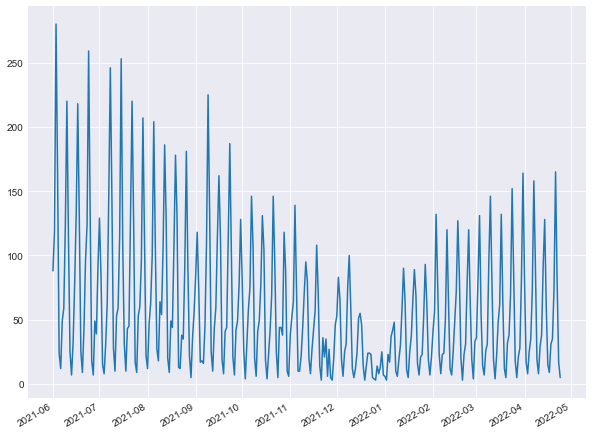

In [278]:
pd.to_datetime(listing_wa_lead["ACTIVE_DATE_C"]).value_counts().plot()

<AxesSubplot:>

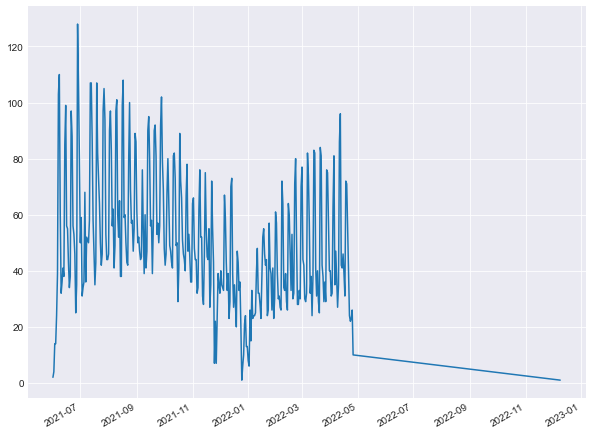

In [279]:
pd.to_datetime(listing_wa_lead["PURCHASE_CONTRACT_DATE_C"]).value_counts().plot()

<AxesSubplot:>

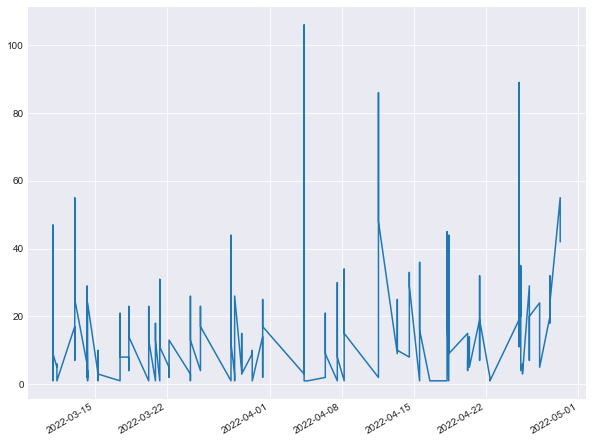

In [280]:
pd.to_datetime(listing_wa_lead["LAST_MODIFIED_DATE"]).value_counts().plot()

<AxesSubplot:>

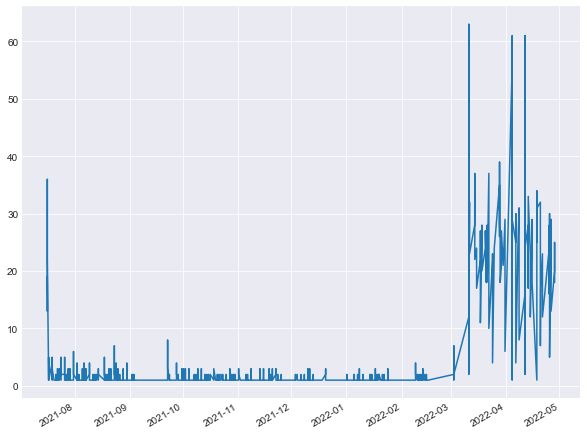

In [281]:
pd.to_datetime(listing_wa_lead["CREATED_DATE"]).value_counts().plot()

In [268]:
listing_wa_lead["CREATED_DATE"].describe()

/var/folders/3j/z2qkp3593qx624tzwlfnllkr0000gn/T/ipykernel_962/549449280.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  listing_wa_lead["CREATED_DATE"].describe()


count                          5881
unique                         3359
top       2022-03-10 21:41:07-08:00
freq                             22
first     2021-07-16 13:28:14-07:00
last      2022-04-25 10:02:01-07:00
Name: CREATED_DATE, dtype: object

In [266]:
listing_wa_lead.shape

(5881, 47)

In [255]:
pd.to_datetime(listing_wa_lead["PURCHASE_CONTRACT_DATE_C"]).min()

Timestamp('2021-06-03 00:00:00')

In [256]:
pd.to_datetime(listing_wa_lead["ACTIVE_DATE_C"]).min()

Timestamp('2021-06-01 00:00:00')

In [249]:
listing_wa_lead_cutoff = listing_wa_lead[(pd.to_datetime(listing_wa_lead["ACTIVE_DATE_C"]).dt.date >= dt.date(2021,6,1))&(pd.to_datetime(listing_wa_lead["ACTIVE_DATE_C"]).dt.date < dt.date(2021,12,1))]

In [250]:
# listing_wa_lead_cutoff.to_csv("listing_wa_lead_cutoff.csv")

In [55]:
# ax = listing_wa_lead.groupby("LEAD_C")["LIST_PRICE_C"].sum().sort_values(ascending = False).head(50).plot(kind = "barh")
# ax.invert_yaxis()
# plt.show()

In [56]:
listing_wa_lead.dtypes

index                                                         int64
ID                                                           object
OWNER_ID                                                     object
IS_DELETED                                                     bool
NAME                                                         object
CREATED_DATE                    datetime64[ns, America/Los_Angeles]
CREATED_BY_ID                                                object
LAST_MODIFIED_DATE              datetime64[ns, America/Los_Angeles]
LAST_MODIFIED_BY_ID                                          object
SYSTEM_MODSTAMP                 datetime64[ns, America/Los_Angeles]
LAST_ACTIVITY_DATE                                           object
LAST_VIEWED_DATE                datetime64[ns, America/Los_Angeles]
LAST_REFERENCED_DATE            datetime64[ns, America/Los_Angeles]
ADDRESS_C                                                    object
CITY_C                                          

In [57]:
listing_wa_lead.columns

Index(['index', 'ID', 'OWNER_ID', 'IS_DELETED', 'NAME', 'CREATED_DATE',
       'CREATED_BY_ID', 'LAST_MODIFIED_DATE', 'LAST_MODIFIED_BY_ID',
       'SYSTEM_MODSTAMP', 'LAST_ACTIVITY_DATE', 'LAST_VIEWED_DATE',
       'LAST_REFERENCED_DATE', 'ADDRESS_C', 'CITY_C', 'LIST_AGENT_EMAIL_C',
       'LIST_AGENT_FULL_NAME_C', 'LIST_AGENT_PREFERRED_PHONE_C',
       'LIST_AGENT_STATE_LICENSE_C', 'LIST_OFFICE_EMAIL_C',
       'LIST_OFFICE_MLS_ID_C', 'LIST_OFFICE_NAME_C', 'LIST_OFFICE_PHONE_C',
       'LIST_PRICE_C', 'LISTING_AGENT_MLS_ID_C', 'LISTING_TERMS_C',
       'MLS_LISTING_NUMBER_C', 'MLS_STATUS_C', 'PARCEL_NUMBER_C',
       'POSTAL_CODE_PLUS_4_C', 'POSTAL_CODE_C', 'PREFERRED_TITLE_AND_ESCROW_C',
       'PRIVATE_REMARKS_C', 'PROPERTY_TYPE_C', 'PURCHASE_CONTRACT_DATE_C',
       'STANDARD_STATUS_C', 'STATE_OR_PROVINCE_C', 'UNPARSED_ADDRESS_C',
       'ZONING_DESCRIPTION_C', 'CONTACT_C', 'LEAD_C', 'MLS_BOARD_C',
       'LISTING_CONTRACT_DATE_C', 'ACTIVE_DATE_C', '_FIVETRAN_SYNCED'],
      dtype

In [58]:
### seems that ACTIVE_DATE_C is the listing date

In [59]:
listing_wa_lead["ACTIVE_DATE_C"].min()

datetime.date(2021, 6, 1)

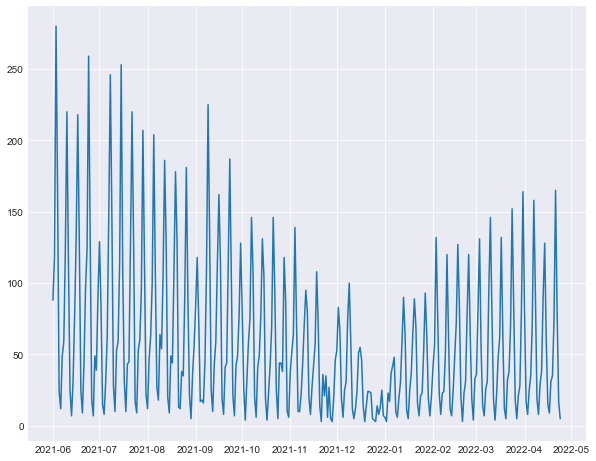

In [60]:
listing_wa_lead["ACTIVE_DATE_C"].value_counts().plot()
plt.show()

In [61]:
wa_lead_hist[wa_lead_hist["NEW_VALUE"] == "Committed"]["CREATED_DATE"].min()

Timestamp('2020-06-01 11:58:57-0700', tz='America/Los_Angeles')

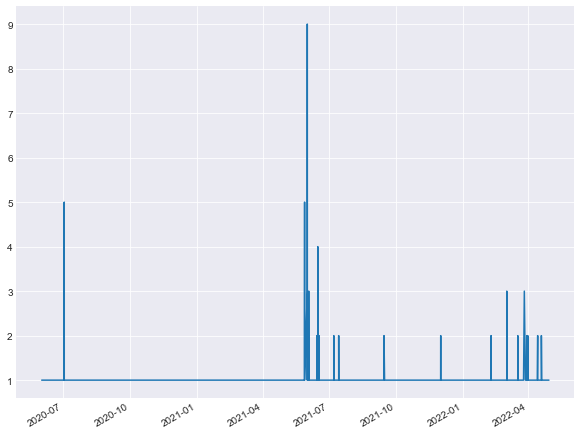

In [62]:
wa_lead_hist[wa_lead_hist["NEW_VALUE"] == "Committed"]["CREATED_DATE"].value_counts().plot()
plt.show()

In [63]:
wa_lead["CREATED_DATE"].min()

Timestamp('2018-08-07 12:53:19-0700', tz='America/Los_Angeles')

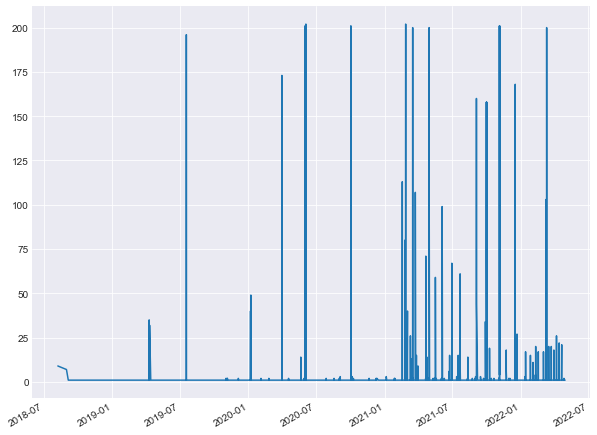

In [228]:
lead["CREATED_DATE"].value_counts().plot()
plt.show()

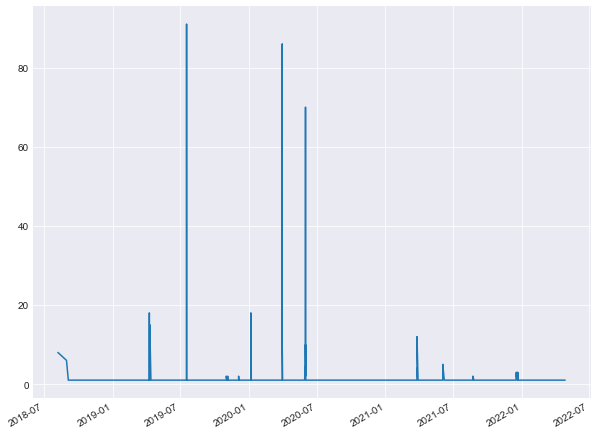

In [64]:
wa_lead["CREATED_DATE"].value_counts().plot()
plt.show()

In [65]:
# group by lead id, pick the latest status date, and use that date to aggregate listing information
last_status_dt = wa_lead_hist_status.loc[wa_lead_hist_status.groupby("LEAD_ID")["CREATED_DATE"].idxmax()][["LEAD_ID","CREATED_DATE"]]
last_status_dt.rename(columns = {"CREATED_DATE":"LAST_STATUS_DATE"}, inplace = True)
last_status_dt.head()

,LEAD_ID,LAST_STATUS_DATE
245110,00Q1H000013ysKnUAI,2021-06-01 10:39:06-07:00
54613,00Q1H000013ysKpUAI,2020-07-05 14:45:41-07:00
489878,00Q1H000014wKDTUA2,2020-07-21 10:46:04-07:00
63612,00Q1H000014wKDVUA2,2020-07-22 08:56:26-07:00
1070209,00Q1H000014xQRqUAM,2021-06-01 10:23:55-07:00


In [66]:
listing_wa_lead = listing_wa_lead.merge(last_status_dt, left_on= "LEAD_C", right_on= "LEAD_ID")
listing_wa_lead = listing_wa_lead[listing_wa_lead["CREATED_DATE"]<= listing_wa_lead["LAST_STATUS_DATE"]]


In [67]:
print(listing_wa_lead["LEAD_C"].nunique())
print(listing_wa_lead.shape)

705
(5881, 47)


In [68]:
listing_wa_lead.head(3)

,index,ID,OWNER_ID,IS_DELETED,NAME,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,ADDRESS_C,CITY_C,LIST_AGENT_EMAIL_C,LIST_AGENT_FULL_NAME_C,LIST_AGENT_PREFERRED_PHONE_C,LIST_AGENT_STATE_LICENSE_C,LIST_OFFICE_EMAIL_C,LIST_OFFICE_MLS_ID_C,LIST_OFFICE_NAME_C,LIST_OFFICE_PHONE_C,LIST_PRICE_C,LISTING_AGENT_MLS_ID_C,LISTING_TERMS_C,MLS_LISTING_NUMBER_C,MLS_STATUS_C,PARCEL_NUMBER_C,POSTAL_CODE_PLUS_4_C,POSTAL_CODE_C,PREFERRED_TITLE_AND_ESCROW_C,PRIVATE_REMARKS_C,PROPERTY_TYPE_C,PURCHASE_CONTRACT_DATE_C,STANDARD_STATUS_C,STATE_OR_PROVINCE_C,UNPARSED_ADDRESS_C,ZONING_DESCRIPTION_C,CONTACT_C,LEAD_C,MLS_BOARD_C,LISTING_CONTRACT_DATE_C,ACTIVE_DATE_C,_FIVETRAN_SYNCED,LEAD_ID,LAST_STATUS_DATE
13,25717,a021H00000NG4mbQAD,0051H00000BeVAmQAN,False,L-00014075,2021-07-16 13:29:31-07:00,0051H00000BeVAmQAN,2022-03-13 00:33:03-08:00,0058V00000C7vv8QAB,2022-03-13 00:33:03-08:00,None,NaT,NaT,"16506 164TH AVE N E, WOODINVILLE, WA 98072, USA",Woodinville,None,Jill Sjolin,425-483-5100,None,woodinville@windermere.com,6007,Windermere Real Estate/HLC,425-483-5100,1698000.0,33044,"Cash,Conventional,VA Loan",1759994,Sold,1226059082,8975,98072,WFG,"Showings start 6/3 4pm-8pm, ENDS Sunday at 3pm...",Residential,2021-06-04,Sold,WA,None,COUNTY,None,00Q1H00001Ewf5VUAR,NWMLS,None,2021-06-03,2022-03-13 00:41:21.686000-08:00,00Q1H00001Ewf5VUAR,2021-08-17 13:44:19-07:00
14,26695,a021H00000NG5VoQAL,0051H00000BeVAmQAN,False,L-00016878,2021-07-16 13:30:28-07:00,0051H00000BeVAmQAN,2022-03-13 00:34:24-08:00,0058V00000C7vv8QAB,2022-03-13 00:34:24-08:00,None,NaT,NaT,"23629 MOUNT FOREST BLVD, MONROE, WA 98272, USA",Monroe,None,Jill Sjolin,425-483-5100,None,woodinville@windermere.com,6007,Windermere Real Estate/HLC,425-483-5100,639000.0,33044,"Cash,Conventional,FHA,VA Loan",1778860,Sold,00630500002200,9414,98272,WFG,"WFG title & escrow, offers due Tues 9am",Residential,2021-06-08,Sold,WA,None,COUNTY,None,00Q1H00001Ewf5VUAR,NWMLS,None,2021-06-03,2022-03-13 00:41:28.638000-08:00,00Q1H00001Ewf5VUAR,2021-08-17 13:44:19-07:00
15,33125,a021H00000NG6JcQAL,0051H00000BeVAmQAN,False,L-00019966,2021-07-16 13:31:28-07:00,0051H00000BeVAmQAN,2022-03-13 00:35:58-08:00,0058V00000C7vv8QAB,2022-03-13 00:35:59-08:00,None,NaT,NaT,"4200 132ND AVE N E, BELLEVUE, WA 98005, USA",Bellevue,None,Jill Sjolin,425-483-5100,None,woodinville@windermere.com,6007,Windermere Real Estate/HLC,425-483-5100,4500000.0,33044,"Cash,Conventional",1772831,Sold,1525059237,1115,98005,None,"6 bdrms, 4 bed septic. Call LB for gate code. ...",Residential,2021-06-21,Sold,WA,None,None,None,00Q1H00001Ewf5VUAR,NWMLS,None,2021-06-05,2022-03-13 00:41:36.504000-08:00,00Q1H00001Ewf5VUAR,2021-08-17 13:44:19-07:00


In [69]:
# things that can be aggregate
# listing price: avg / sum
# STATE_OR_PROVINCE_C:  nunique
# PROPERTY_TYPE_C : nunique, mode
# CITY_C: nunique
# ID: nunique (number of listings)

### Salesforce Share wallet fields

- Total Transaction Count
- Total Sales
- Listing Count
- LS Sales
- BS Count
- BS Sales
- Preferred Title Co.
- Secondary Title Co.
- Preferred Escrow Co.
- Secondary Escrow Co.
- Preferred Title SOW
- Total Directed Title Transactions
- Preferred Escrow SOW
- Total Directed Escrow Transactions
- Average Close Price
- FA Directed Transations


In [70]:
# columns that in the Salesforce dataset
wallet_share_col = ["TOTAL_TRANSACTION_COUNT_C",
                    "TOTAL_SALES_C",
                    "TOTAL_LISTING_COUNT_C",
                    "LS_SALES_C",
                    "BS_COUNT_C",
                    "BS_SALES_C",
                    "PREFERRED_TITLE_COMPANY_C",
                    "SECONDARY_TITLE_CO_C",
                    "SECONDARY_ESCROW_CO_C",
                    # PREFERRED TITLE SOW NOT FOUND IN DATA
                    # TOTAL DIRECTED TITLE TRANSACTIONS NOT FOUND IN DATA
                    "PREFERRED_ESCROW_SOW_C",
                    "TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C",
                    "AVERAGE_CLOSE_PRICE_C",
                    "FA_DIRECTED_TRANSACTIONS_C"
                    ]

In [71]:
#n_missing in overall leads
for col in wallet_share_col:
    num_empty = lead[col].isnull().sum()
    prop = num_empty / len(lead)
    print("{} Column: {:20} -- % Missing: {:.4f}".format("!" if prop > 0.3 else "",col,prop)) # try to align the dash to make the number aligned

! Column: TOTAL_TRANSACTION_COUNT_C -- % Missing: 0.9178
! Column: TOTAL_SALES_C        -- % Missing: 0.9973
! Column: TOTAL_LISTING_COUNT_C -- % Missing: 0.8405
! Column: LS_SALES_C           -- % Missing: 0.9972
! Column: BS_COUNT_C           -- % Missing: 0.8657
! Column: BS_SALES_C           -- % Missing: 0.9987
! Column: PREFERRED_TITLE_COMPANY_C -- % Missing: 0.9907
! Column: SECONDARY_TITLE_CO_C -- % Missing: 1.0000
! Column: SECONDARY_ESCROW_CO_C -- % Missing: 1.0000
! Column: PREFERRED_ESCROW_SOW_C -- % Missing: 0.9999
! Column: TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C -- % Missing: 0.9999
! Column: AVERAGE_CLOSE_PRICE_C -- % Missing: 0.8439
! Column: FA_DIRECTED_TRANSACTIONS_C -- % Missing: 0.9999


In [72]:
# n_missing in wa_leads
for col in wallet_share_col:
    num_empty = wa_lead[col].isnull().sum()
    prop = num_empty / len(wa_lead)
    print("{} Column: {:20} -- % Missing: {:.4f}".format("!" if prop > 0.3 else "",col,prop)) # try to align the dash to make the number aligned

! Column: TOTAL_TRANSACTION_COUNT_C -- % Missing: 0.8788
! Column: TOTAL_SALES_C        -- % Missing: 0.9190
 Column: TOTAL_LISTING_COUNT_C -- % Missing: 0.2626
! Column: LS_SALES_C           -- % Missing: 0.9215
! Column: BS_COUNT_C           -- % Missing: 0.9899
! Column: BS_SALES_C           -- % Missing: 0.9970
! Column: PREFERRED_TITLE_COMPANY_C -- % Missing: 0.6751
! Column: SECONDARY_TITLE_CO_C -- % Missing: 0.9996
! Column: SECONDARY_ESCROW_CO_C -- % Missing: 1.0000
! Column: PREFERRED_ESCROW_SOW_C -- % Missing: 0.9999
! Column: TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C -- % Missing: 0.9999
! Column: AVERAGE_CLOSE_PRICE_C -- % Missing: 0.4070
! Column: FA_DIRECTED_TRANSACTIONS_C -- % Missing: 0.9999


In [73]:
listing_wa_lead.groupby("LEAD_C").agg(
    LIST_PRICE_MEAN=pd.NamedAgg(column="LIST_PRICE_C", aggfunc="mean"),
    LIST_PRICE_SUM =pd.NamedAgg(column="LIST_PRICE_C", aggfunc="sum"),
    N_LISTING=pd.NamedAgg(column="ID", aggfunc="nunique"),
    N_CITY =pd.NamedAgg(column="CITY_C", aggfunc="nunique"),
    N_STATE = pd.NamedAgg(column="STATE_OR_PROVINCE_C", aggfunc="nunique"),
    N_PROP_TYPE = pd.NamedAgg(column="PROPERTY_TYPE_C", aggfunc="nunique"),

    )

,LIST_PRICE_MEAN,LIST_PRICE_SUM,N_LISTING,N_CITY,N_STATE,N_PROP_TYPE
LEAD_C,,,,,,
00Q1H000017xpmoUAA,484000.000000,968000.0,2,1,1,1
00Q1H0000180LLdUAM,825833.333333,4955000.0,6,2,1,1
00Q1H000018YExxUAG,664990.000000,664990.0,1,1,1,1
00Q1H000018aCDGUA2,640255.277778,11524595.0,18,7,1,2
00Q1H000018aHQxUAM,965571.428571,20277000.0,21,7,1,1
...,...,...,...,...,...,...
00Q1H00001FdQgKUAV,384500.000000,769000.0,2,1,1,1
00Q1H00001FdR3sUAF,380311.111111,6845600.0,18,7,1,2
00Q1H00001FdR3wUAF,143737.500000,1149900.0,8,2,1,2


#### Salesforce Task

In [74]:
query = "SELECT * FROM lake.salesforce.task WHERE WHO_ID IN (SELECT ID from lake.salesforce.lead WHERE (lower(STATE) LIKE 'wa%'))"
wa_task = cur.execute(query).fetch_pandas_all().reset_index()

In [75]:
wa_task["ACTIVITY_DATE"] = pd.to_datetime(wa_task["ACTIVITY_DATE"])

In [76]:
wa_task.head()

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED
0,0,00T8V00004jD7PMUA0,00Q1H00001FdGRwUAN,None,1,0,"Opened: Welcome to Endpoint Closing, a First A...",2021-10-14,Completed,Normal,False,0051H000008sMEFQA2,To: paulgraf@remax.net\nCc: \nBcc: \nView orig...,#N/A,False,None,True,2021-10-14 07:33:02-07:00,0051H000008sMEFQA2,2021-10-14 07:33:02-07:00,0051H000008sMEFQA2,2021-10-14 07:33:02-07:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Email,2021-10-14 07:33:02-07:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2021-10-14 07:52:33.700000-07:00,None,None,False,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,None,None,NaN,None,NaT,None,None,NaT,None,None,None,None
1,1,00T8V00004mwZMuUAM,00Q1H00001FdFX0UAN,None,1,0,Unanswered Call - No Voicemail,2021-12-07,Completed,Normal,False,0051H00000BQkufQAD,None,None,False,None,True,2021-12-07 11:25:17-08:00,0051H00000BQkufQAD,2021-12-07 11:25:17-08:00,0051H00000BQkufQAD,2021-12-07 11:25:17-08:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Call,2021-12-07 11:25:17-08:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2021-12-07 12:44:56.808000-08:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,False,None,NaN,False,NaT,None,None,NaT,None,None,None,None
2,2,00T8V00004t7LWzUAM,00Q1H00001Ewfj7UAB,None,1,0,Call: No Answer,2022-04-21,Completed,Normal,False,0058V00000C7yglQAB,None,Call,False,None,True,2022-04-21 09:01:43-07:00,0058V00000C7yglQAB,2022-04-21 09:01:52-07:00,0058V00000C7yglQAB,2022-04-21 09:01:52-07:00,3.0,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Call,2

In [237]:
wa_task_cutoff = wa_task[(wa_task["ACTIVITY_DATE"].dt.date >= dt.date(2021,6,1)) &(wa_task["ACTIVITY_DATE"].dt.date <= dt.date(2021,12,1))]

In [238]:
wa_task_cutoff = wa_task_cutoff.to_csv("wa_task_cutoff.csv")

In [77]:
#using 06/01/2021 as converted date, count the population, look at the activity 6 months later (<= 2020-11-30)
# to see if any status changes

In [78]:
june_lead_id = wa_task[wa_task["ACTIVITY_DATE"] <= pd.to_datetime("2020-06-01")]["WHO_ID"].to_list()

In [79]:
len(june_lead_id)

5268

In [80]:
# filter out leads who CREATED_DATE <= cutoff date start, summarize the status 
# using the id from those leads to subset tasks range from (cutoff date start, cutoff date end)
# summarize the attributes: 
# lead: most recent status, 
# lead_hist:status changes count
# task: total activity, total phone call, total email, other

In [81]:
cutoff_date_start = dt.date(2021,6,1)
cutoff_date_end = dt.date(2021,12,1)

In [82]:
cutoff_wa_lead = wa_lead[wa_lead["CREATED_DATE"].dt.date <= cutoff_date_start]

In [83]:
cutoff_wa_task = wa_task[(wa_task["WHO_ID"].isin(cutoff_wa_lead["ID"]))&(wa_task["ACTIVITY_DATE"].dt.date >= cutoff_date_start) & (wa_task["ACTIVITY_DATE"].dt.date < cutoff_date_end)]

In [84]:
# in wa_lead_hist_status, use cutoff_wa_lead["ID"], and cutoff_date_start, create the cutoff_status_start
# in wa_lead_hist_status, use cutoff_wa_lead["ID"], and cutoff_date_end, create the cutoff_status_end

In [85]:
cutoff_start_wa_lead_hist_status = wa_lead_hist_status[(wa_lead_hist_status["LEAD_ID"].isin(cutoff_wa_lead["ID"]))& (wa_lead_hist_status["CREATED_DATE"].dt.date <= cutoff_date_start)]
cutoff_status_start = cutoff_start_wa_lead_hist_status.loc[cutoff_start_wa_lead_hist_status.groupby("LEAD_ID")["CREATED_DATE"].idxmax(),["LEAD_ID","NEW_VALUE","CREATED_DATE"]]
cutoff_status_start

,LEAD_ID,NEW_VALUE,CREATED_DATE
245110,00Q1H000013ysKnUAI,Committed,2021-06-01 10:39:06-07:00
54613,00Q1H000013ysKpUAI,Disqualified,2020-07-05 14:45:41-07:00
489878,00Q1H000014wKDTUA2,Committed,2020-07-21 10:46:04-07:00
63612,00Q1H000014wKDVUA2,Committed,2020-07-22 08:56:26-07:00
1070209,00Q1H000014xQRqUAM,Committed,2021-06-01 10:23:55-07:00
...,...,...,...
147364,00Q1H00001KFVkCUAX,Committed,2021-05-24 11:36:19-07:00
2316925,00Q1H00001KFsGEUA1,Committed,2021-06-01 10:54:41-07:00
1339280,00Q1H00001Kb0EWUAZ,Committed,2021-06-01 10:40:27-07:00
2294635,00Q1H00001Kb3m8UAB,Committed,2021-05-27 12:04:10-07:00


In [86]:
cutoff_end_wa_lead_hist_status = wa_lead_hist_status[(wa_lead_hist_status["LEAD_ID"].isin(cutoff_wa_lead["ID"]))& (wa_lead_hist_status["CREATED_DATE"].dt.date <= cutoff_date_end)]
cutoff_status_end = cutoff_end_wa_lead_hist_status.loc[cutoff_end_wa_lead_hist_status.groupby("LEAD_ID")["CREATED_DATE"].idxmax(),["LEAD_ID","NEW_VALUE","CREATED_DATE"]]
cutoff_status_end

,LEAD_ID,NEW_VALUE,CREATED_DATE
245110,00Q1H000013ysKnUAI,Committed,2021-06-01 10:39:06-07:00
54613,00Q1H000013ysKpUAI,Disqualified,2020-07-05 14:45:41-07:00
489878,00Q1H000014wKDTUA2,Committed,2020-07-21 10:46:04-07:00
63612,00Q1H000014wKDVUA2,Committed,2020-07-22 08:56:26-07:00
1070209,00Q1H000014xQRqUAM,Committed,2021-06-01 10:23:55-07:00
...,...,...,...
2424146,00Q1H00001KayV8UAJ,Committed,2021-06-17 12:34:28-07:00
1339280,00Q1H00001Kb0EWUAZ,Committed,2021-06-01 10:40:27-07:00
2294635,00Q1H00001Kb3m8UAB,Committed,2021-05-27 12:04:10-07:00
17779,00Q1H00001Kb3mmUAB,Committed,2021-05-27 12:07:25-07:00


In [87]:
cutoff_status_start_end = cutoff_status_start.merge(cutoff_status_end, on = "LEAD_ID", suffixes=("_START","_END"))
cutoff_status_start_end

,LEAD_ID,NEW_VALUE_START,CREATED_DATE_START,NEW_VALUE_END,CREATED_DATE_END
0,00Q1H000013ysKnUAI,Committed,2021-06-01 10:39:06-07:00,Committed,2021-06-01 10:39:06-07:00
1,00Q1H000013ysKpUAI,Disqualified,2020-07-05 14:45:41-07:00,Disqualified,2020-07-05 14:45:41-07:00
2,00Q1H000014wKDTUA2,Committed,2020-07-21 10:46:04-07:00,Committed,2020-07-21 10:46:04-07:00
3,00Q1H000014wKDVUA2,Committed,2020-07-22 08:56:26-07:00,Committed,2020-07-22 08:56:26-07:00
4,00Q1H000014xQRqUAM,Committed,2021-06-01 10:23:55-07:00,Committed,2021-06-01 10:23:55-07:00
...,...,...,...,...,...
5994,00Q1H00001KFVkCUAX,Committed,2021-05-24 11:36:19-07:00,Committed,2021-05-24 11:36:19-07:00
5995,00Q1H00001KFsGEUA1,Committed,2021-06-01 10:54:41-07:00,Committed,2021-06-01 10:54:41-07:00
5996,00Q1H00001Kb0EWUAZ,Committed,2021-06-01 10:40:27-07:00,Committed,2021-06-01 10:40:27-07:00
5997,00Q1H00001Kb3m8UAB,Committed,2021-05-27 12:04:10-07:00,Committed,2021-05-27 12:04:10-07:00


In [88]:
cutoff_status_start_end[cutoff_status_start_end["CREATED_DATE_START"]!=cutoff_status_start_end["CREATED_DATE_END"]][["NEW_VALUE_START","NEW_VALUE_END"]].value_counts()

NEW_VALUE_START  NEW_VALUE_END
New              Committed        718
                 Working          163
                 Disqualified     121
Disqualified     Committed         69
Working          Committed         66
Disqualified     Disqualified      48
Working          Disqualified      27
Disqualified     Working            4
Demoed           Committed          2
New              New                2
Qualified        Committed          1
Working          Working            1
dtype: int64

In [89]:
cutoff_status_start_end[(cutoff_status_start_end["NEW_VALUE_START"] == "Disqualified")& (cutoff_status_start_end["NEW_VALUE_END"] == "Committed")]

,LEAD_ID,NEW_VALUE_START,CREATED_DATE_START,NEW_VALUE_END,CREATED_DATE_END
65,00Q1H000018alTfUAI,Disqualified,2020-07-05 14:34:13-07:00,Committed,2021-10-19 12:02:59-07:00
84,00Q1H00001AFLgrUAH,Disqualified,2020-07-05 14:46:42-07:00,Committed,2021-06-17 12:33:03-07:00
87,00Q1H00001AGEVxUAP,Disqualified,2020-07-05 14:44:49-07:00,Committed,2021-06-17 12:27:40-07:00
185,00Q1H00001BL8ZMUA1,Disqualified,2020-06-30 13:06:20-07:00,Committed,2021-06-17 12:39:13-07:00
251,00Q1H00001BL8c4UAD,Disqualified,2020-07-05 14:45:16-07:00,Committed,2021-06-17 12:25:02-07:00
333,00Q1H00001BL8ftUAD,Disqualified,2020-11-23 20:03:30-08:00,Committed,2021-07-14 13:33:27-07:00
375,00Q1H00001BL8hsUAD,Disqualified,2020-07-05 14:46:08-07:00,Committed,2021-09-07 12:06:50-07:00
411,00Q1H00001BL8jjUAD,Disqualified,2020-06-03 18:00:34-07:00,Committed,2021-07-14 20:02:43-07:00
547,00Q1H00001BwsWKUAZ,Disqualified,2020-05-29 10:29:17-07:00,Committed,2021-07-14 14:11:12-07:00
626,00Q1H00001C01LCUAZ,Disqualified,2020-06-30 14:19:34-07:00,Committed,2021-11-03 09:44:53-07:00


In [90]:
wa_task[wa_task["WHO_ID"].isin(cutoff_status_start_end[(cutoff_status_start_end["NEW_VALUE_START"] == "Disqualified") & (cutoff_status_start_end["NEW_VALUE_END"] == "Committed")]["LEAD_ID"])]

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED


In [91]:
wa_task[(wa_task["WHO_ID"] == "00Q1H000018alTfUAI")& (wa_task["ACTIVITY_DATE"].dt.date >= cutoff_date_start)& (wa_task["ACTIVITY_DATE"].dt.date <= cutoff_date_end) ]

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED


In [92]:
wa_lead_hist[wa_lead_hist["LEAD_ID"] == "00Q1H000018alTfUAI"]

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
138830,30468,0171H0000xhm7NBQAY,False,00Q1H000018alTfUAI,0051H000008rwTGQAY,2020-07-02 11:57:53-07:00,Disqualified_Reasons__c,DynamicEnum,DQ - First Am Loyal,None,2021-09-07 17:03:23.213000-07:00
603115,194015,0171H0000xdiOWgQAM,False,00Q1H000018alTfUAI,0051H000008rwTGQAY,2020-06-29 22:40:29-07:00,Disqualified_Reasons__c,DynamicEnum,None,DQ - First Am Loyal,2021-09-07 17:03:23.576000-07:00
622853,425,0178V00015QoPoFQAV,False,00Q1H000018alTfUAI,0051H00000BeVAmQAN,2021-10-19 12:02:59-07:00,Status,DynamicEnum,Disqualified,Committed,2021-10-19 13:42:52.901000-07:00
622865,437,0178V00015QoPMmQAN,False,00Q1H000018alTfUAI,0051H00000BeVAmQAN,2021-10-19 12:02:58-07:00,leadConverted,Text,None,None,2021-10-19 13:42:52.910000-07:00
622903,475,0178V00015QoPoGQAV,False,00Q1H000018alTfUAI,0051H00000BeVAmQAN,2021-10-19 12:02:59-07:00,Status,DynamicEnum,Committed,Disqualified,2021-10-19 13:42:52.901000-07:00
1011600,11377,0171H0000xk1AXqQAM,False,00Q1H000018alTfUAI,0051H000008rwTGQAY,2020-07-05 14:34:13-07:00,Disqualified_Reasons__c,DynamicEnum,None,DQ - First Am Loyal,2021-09-07 17:03:23.203000-07:00
1186455,30946,0171H0000xhm7NAQAY,False,00Q1H000018alTfUAI,0051H000008rwTGQAY,2020-07-02 11:57:53-07:00,Status,DynamicEnum,Disqualified,Working,2021-09-07 17:03:03.995000-07:00
2396301,40697,0171H0000xdiOaTQAU,False,00Q1H000018alTfUAI,0051H000008rwTGQAY,2020-06-29 22:40:29-07:00,Status,DynamicEnum,Working,Disqualified,2021-09-07 17:03:04.264000-07:00
2422188,66584,0171H0000xk1AXpQAM,False,00Q1H000018alTfUAI,0051H000008rwTGQAY,2020-07-05 14:34:13-07:00,Status,DynamicEnum,Working,Disqualified,2021-09-07 17:03:03.987000-07:00


In [93]:
wa_task[(wa_task["WHO_ID"] == "00Q1H00001KE579UAD")& (wa_task["ACTIVITY_DATE"].dt.date >= cutoff_date_start)& (wa_task["ACTIVITY_DATE"].dt.date <= cutoff_date_end) ]

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED


In [94]:
wa_lead_hist[wa_lead_hist["LEAD_ID"] == "00Q1H00001KE579UAD"]

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
59050,5383,0171H00013ZYxi9QAD,False,00Q1H00001KE579UAD,0051H00000AeGKuQAN,2021-05-28 15:33:41-07:00,Last_Modified__c,DateOnly,2021-05-04,2021-05-28,2021-09-07 17:03:31.575000-07:00
60139,6472,0171H00013ZYxiAQAT,False,00Q1H00001KE579UAD,0051H00000AeGKuQAN,2021-05-28 15:33:41-07:00,Status,DynamicEnum,New,Disqualified,2021-09-07 17:03:02.415000-07:00
135649,27287,0171H00013DASbeQAH,False,00Q1H00001KE579UAD,0051H00000AeGKuQAN,2021-05-04 15:58:25-07:00,created,Text,None,None,2021-09-07 17:04:40.506000-07:00
135957,27595,0171H00013DASbgQAH,False,00Q1H00001KE579UAD,0051H00000AeGKuQAN,2021-05-04 15:58:25-07:00,MobilePhone,Phone,425-628-9841,(425) 628-9841,2021-09-07 17:03:55.548000-07:00
599132,190032,0171H00013sfhBkQAI,False,00Q1H00001KE579UAD,0051H00000BeVAmQAN,2021-06-17 12:31:55-07:00,Status,DynamicEnum,Disqualified,Committed,2021-09-07 17:03:01.977000-07:00
994479,22855,0171H00013sfhP3QAI,False,00Q1H00001KE579UAD,0051H00000BeVAmQAN,2021-06-17 12:31:55-07:00,Status,DynamicEnum,Committed,Disqualified,2021-09-07 17:03:01.977000-07:00
1106913,51728,0171H00013ZYxi8QAD,False,00Q1H00001KE579UAD,0051H00000AeGKuQAN,2021-05-28 15:33:41-07:00,Disqualified_Reasons__c,DynamicEnum,None,DQ - Nurture,2021-09-07 17:03:22.693000-07:00
1183578,28069,0171H00013DASbfQAH,False,00Q1H00001KE579UAD,0051H00000AeGKuQAN,2021-05-04 15:58:25-07:00,Last_Modified__c,DateOnly,None,2021-05-04,2021-09-07 17:03:33.728000-07:00
2349794,49151,0171H00013sfhBhQAI,False,00Q1H00001KE579UAD,0051H00000BeVAmQAN,2021-06-17 12:31:53-07:00,leadConverted,Text,None,None,2021-09-07 17:03:27.334000-07:00


In [95]:
wa_lead_hist_status_agg[wa_lead_hist_status_agg["LEAD_ID"].isin(cutoff_status_start_end[(cutoff_status_start_end["NEW_VALUE_START"] == "Disqualified")& (cutoff_status_start_end["NEW_VALUE_END"] == "Committed")]["LEAD_ID"])].head(20)

,LEAD_ID,VALUE_AGG,VALUE_AGG_CLEAN,VALUE_AGG_START,VALUE_AGG_END,COMMITTED_DATE_MIN,COMMITTED_DATE_MAX,DISQUALIFIED_DATE_MIN,DISQUALIFIED_DATE_MAX,WORKING_DATE_MIN,WORKING_DATE_MAX
84,00Q1H000018alTfUAI,"Working-Disqualified,Disqualified-Working,Work...","Working,Disqualified,Working,Disqualified,Comm...",Working,Disqualified,2021-10-19 12:02:59-07:00,2021-10-19 12:02:59-07:00,2020-06-29 22:40:29-07:00,2021-10-19 12:02:59-07:00,2020-07-02 11:57:53-07:00,2020-07-02 11:57:53-07:00
105,00Q1H00001AFLgrUAH,"New-Disqualified,Disqualified-Committed,Commit...","New,Disqualified,Committed,Disqualified",New,Disqualified,2021-06-17 12:33:03-07:00,2021-06-17 12:33:03-07:00,2020-07-05 14:46:42-07:00,2021-06-17 12:33:03-07:00,NaT,NaT
109,00Q1H00001AGEVxUAP,"Working-Disqualified,Disqualified-Working,Work...","Working,Disqualified,Working,Disqualified,Comm...",Working,Disqualified,2021-06-17 12:27:40-07:00,2021-06-17 12:27:40-07:00,2020-06-29 22:42:50-07:00,2021-06-17 12:27:40-07:00,2020-07-02 11:53:17-07:00,2020-07-02 11:53:17-07:00
219,00Q1H00001BL8ZMUA1,"Working-Disqualified,Disqualified-Committed,Co...","Working,Disqualified,Committed,Disqualified",Working,Disqualified,2021-06-17 12:39:13-07:00,2021-06-17 12:39:13-07:00,2020-06-30 13:06:20-07:00,2021-06-17 12:39:13-07:00,NaT,NaT
289,00Q1H00001BL8c4UAD,"Working-New,New-Disqualified,Disqualified-Comm...","Working,New,Disqualified,Committed,Disqualified",Working,Disqualified,2021-06-17 12:25:02-07:00,2021-06-17 12:25:02-07:00,2020-07-05 14:45:16-07:00,2021-06-17 12:25:02-07:00,NaT,NaT
376,00Q1H00001BL8ftUAD,"Working-Disqualified,Disqualified-Committed,Co...","Working,Disqualified,Committed,Disqualified",Working,Disqualified,2021-07-14 13:33:27-07:00,2021-07-14 13:33:27-07:00,2020-11-23 20:03:30-08:00,2021-07-14 13:33:27-07:00,NaT,NaT
420,00Q1H00001BL8hsUAD,"Working-New,New-Disqualified,Disqualified-Comm...","Working,New,Disqualified,Committed,Disqualified",Working,Disqualified,2021-09-07 12:06:50-07:00,2021-09-07 12:06:50-07:00,2020-07-05 14:46:08-07:00,2021-09-07 12:06:50-07:00,NaT,NaT
461,00Q1H00001BL8jjUAD,"Working-Disqualified,Disqualified-Working,Work...","Working,Disqualified,Working,Disqualified,Work...",Working,Committed,2021-07-14 20:02:43-07:00,2021-07-14 20:02:43-07:00,2020-06-03 18:00:34-07:00,2021-07-14 11:26:20-07:00,2021-07-14 11:26:20-07:00,2021-07-14 11:27:46-07:00
616,00Q1H00001BwsWKUAZ,"Demoed-Disqualified,Disqualified-Committed","Demoed,Disqualified,Committed",Demoed,Committed,2021-07-14 14:11:12-07:00,2021-07-14 14:11:12-07:00,2020-05-29 10:29:17-07:00,2020-05-29 10:29:17-07:00,NaT,NaT
705,00Q1H00001C01LCUAZ,"Working-Disqualified,Disqualified-Committed","Working,Disqualified,Committed",Working,Committed,2021-11-03 09:44:53-07:00,2021-11-03 09:44:53-07:00,2020-06-30 14:19:34-07:00,2020-06-30 14:19:34-07:00,NaT,NaT


#### cutoff_task

In [96]:
wa_task.head()

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED
0,0,00T8V00004jD7PMUA0,00Q1H00001FdGRwUAN,None,1,0,"Opened: Welcome to Endpoint Closing, a First A...",2021-10-14,Completed,Normal,False,0051H000008sMEFQA2,To: paulgraf@remax.net\nCc: \nBcc: \nView orig...,#N/A,False,None,True,2021-10-14 07:33:02-07:00,0051H000008sMEFQA2,2021-10-14 07:33:02-07:00,0051H000008sMEFQA2,2021-10-14 07:33:02-07:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Email,2021-10-14 07:33:02-07:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2021-10-14 07:52:33.700000-07:00,None,None,False,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,None,None,NaN,None,NaT,None,None,NaT,None,None,None,None
1,1,00T8V00004mwZMuUAM,00Q1H00001FdFX0UAN,None,1,0,Unanswered Call - No Voicemail,2021-12-07,Completed,Normal,False,0051H00000BQkufQAD,None,None,False,None,True,2021-12-07 11:25:17-08:00,0051H00000BQkufQAD,2021-12-07 11:25:17-08:00,0051H00000BQkufQAD,2021-12-07 11:25:17-08:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Call,2021-12-07 11:25:17-08:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2021-12-07 12:44:56.808000-08:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,False,None,NaN,False,NaT,None,None,NaT,None,None,None,None
2,2,00T8V00004t7LWzUAM,00Q1H00001Ewfj7UAB,None,1,0,Call: No Answer,2022-04-21,Completed,Normal,False,0058V00000C7yglQAB,None,Call,False,None,True,2022-04-21 09:01:43-07:00,0058V00000C7yglQAB,2022-04-21 09:01:52-07:00,0058V00000C7yglQAB,2022-04-21 09:01:52-07:00,3.0,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Call,2

In [97]:
wa_task.groupby("WHO_ID")["TYPE"].nunique().to_frame()

,TYPE
WHO_ID,
00Q1H000013ysKgUAI,1
00Q1H000013ysKhUAI,0
00Q1H000013ysKkUAI,0
00Q1H000013ysKlUAI,0
00Q1H000013ysKpUAI,1
...,...
00Q8V00001NK9YVUA1,1
00Q8V00001NK9gyUAD,1
00Q8V00001NKECyUAP,1


In [98]:
wa_task[["TYPE","TASK_SUBTYPE"]].value_counts()

TYPE           TASK_SUBTYPE
Call           Call            9641
Email          Email           8243
#N/A           Email           2882
Call           Task             307
Intercom Chat  Task             102
Email          Task              28
Meeting        Email              4
Task           Task               1
dtype: int64

In [99]:
wa_task[(wa_task["ACTIVITY_DATE"].dt.date >= cutoff_date_start) & (wa_task["ACTIVITY_DATE"].dt.date < cutoff_date_end)].groupby("WHO_ID")[["TYPE","TASK_SUBTYPE"]].value_counts()

WHO_ID              TYPE   TASK_SUBTYPE
00Q1H000013ysKgUAI  Email  Email           3
00Q1H000017yIIzUAM  Call   Call            1
00Q1H000018Pm2EUAS  Call   Call            2
                    #N/A   Email           1
                    Email  Email           1
                                          ..
00Q8V00001LBoc3UAD  #N/A   Email           1
00Q8V00001M69hJUAR  Call   Call            1
00Q8V00001M69iCUAR  Call   Call            2
                    Email  Email           1
00Q8V00001M6nJ1UAJ  Call   Call            1
Length: 2895, dtype: int64

### function for rollback the status of the lead

In [100]:
wa_lead.head()

,index,ID,IS_DELETED,MASTER_RECORD_ID,LAST_NAME,FIRST_NAME,SALUTATION,MIDDLE_NAME,SUFFIX,NAME,RECORD_TYPE_ID,TITLE,COMPANY,STREET,CITY,STATE,POSTAL_CODE,COUNTRY,LATITUDE,LONGITUDE,GEOCODE_ACCURACY,PHONE,MOBILE_PHONE,FAX,EMAIL,WEBSITE,PHOTO_URL,DESCRIPTION,LEAD_SOURCE,STATUS,INDUSTRY,RATING,ANNUAL_REVENUE,NUMBER_OF_EMPLOYEES,OWNER_ID,HAS_OPTED_OUT_OF_EMAIL,IS_CONVERTED,CONVERTED_DATE,CONVERTED_ACCOUNT_ID,CONVERTED_CONTACT_ID,CONVERTED_OPPORTUNITY_ID,IS_UNREAD_BY_OWNER,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,DO_NOT_CALL,HAS_OPTED_OUT_OF_FAX,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,LAST_TRANSFER_DATE,JIGSAW,JIGSAW_CONTACT_ID,EMAIL_BOUNCED_REASON,EMAIL_BOUNCED_DATE,INDIVIDUAL_ID,POSTAL_CODE_C,MOST_RECENT_CAMPAIGN_C,ALTERNATE_EMAIL_C,APEX_PROCESSED_C,KNOCK_WEBHOOK_C,ALTERNATE_PHONE_C,TOTAL_SALES_C,BOOK_SIZE_SOW_PREFERRED_C,EMAIL_BOUNCED_C,EVENT_TYPE_C,IS_LEAD_C,AVERAGE_LIST_PRICE_C,FSBO_ADDRESS_C,FSBO_LISTING_PRICE_C,FIRST_TASK_DATE_C,FIRST_EVENT_DATE_C,BROKERAGE_1_C,TOTAL_TRANSACTION_COUNT_C,COUNTY_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NAME_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NEXT_STEP_DUE_DATE_C,SALES_LOFT_1_MOST_RECENT_LAST_COMPLETED_STEP_C,DISQUALIFIED_NOTES_C,FA_LOYAL_LEAD_C,LS_SALES_C,TOTAL_LISTING_COUNT_C,PREFERRED_PROVIDER_BY_LISTING_COUNT_C,PRODUCT_DEMO_DATE_C,PREFERRED_ESCROW_COMPANY_C,ROLE_C,APP_DOWNLOAD_DATE_C,PREFERRED_TITLE_COMPANY_C,AGENT_MLS_ID_C,ORDER_ENTRY_NOTES_C,LEVEL_VETTING_C,LICENSE_NO_C,PARDOT_REASSIGNMENT_C,AGENT_ROLE_C,LISTING_PRICE_C,TOTAL_MODUS_TRANSACTION_COUNT_C,DIGITAL_TE_USER_C,PI_NEEDS_SCORE_SYNCED_C,PI_PARDOT_LAST_SCORED_AT_C,PI_CAMPAIGN_C,PI_COMMENTS_C,PI_CONVERSION_DATE_C,PI_CONVERSION_OBJECT_NAME_C,PI_CONVERSION_OBJECT_TYPE_C,PI_CREATED_DATE_C,PI_FIRST_ACTIVITY_C,PI_FIRST_SEARCH_TERM_C,PI_FIRST_SEARCH_TYPE_C,PI_FIRST_TOUCH_URL_C,PI_GRADE_C,PI_LAST_ACTIVITY_C,PI_NOTES_C,PI_PARDOT_HARD_BOUNCED_C,PI_SCORE_C,PI_URL_C,PI_UTM_CAMPAIGN_C,PI_UTM_CONTENT_C,PI_UTM_MEDIUM_C,PI_UTM_SOURCE_C,PI_UTM_TERM_C,LAST_MODIFIED_C,PREFERRED_PLATFORM_C,AVERAGE_CLOSE_PRICE_C,AVERAGE_TRANSACTION_AMOUNT_C,BS_COUNT_C,DISQUALIFIED_REASONS_C,FA_DIRECTED_ESCROW_TRANSACTIONS_C,FA_DIRECTED_TRANSACTIONS_C,LEAD_NUMBER_C,LEAD_RANKING_C,MATRIX_UNIQUE_ID_C,MEAL_TRACKER_C,PMXAGENT_ID_C,PREFERRED_ESCROW_SOW_C,SECONDARY_ESCROW_CO_C,SECONDARY_TITLE_CO_C,BS_SALES_C,TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C,CHECKBOX_C,NMLS_ID_C,REFERRER_C,PROPERTY_ADDRESS_C,REFERRAL_EMAIL_C,COMING_SOON_ADDRESS_C,KCA_C,_FIVETRAN_SYNCED,EMAIL_UNKNOWN_DELIVERABILITY_C,ACCOUNT_MANAGER_C,SALES_DEVELOPMENT_REP_C,RELATIONSHIP_MANAGER_C,WEB_LEAD_C,KNOCK_WEBHOOK_2021_C,DO_NOT_CONTACT_C,MOBILE_INDEXED_C,DEMO_SET_ON_C,DEMO_SCHEDULED_FOR_C,STATE_STD
333,194,00Q1H00001FdPfNUAV,False,None,Vader,Roshane,None,None,None,Roshane Vader,0121H000000zyGvQAI,None,Compass Washington - 108th Ave,305 108th Avenue NE Suite 200,Bellevue,WA,98004,None,NaN,NaN,None,None,None,None,roshanevader@gmail.com,None,/services/images/photo/00Q1H00001FdPfNUAV,None,MLS Upload,Committed,None,None,NaN,NaN,00G1H000004ldrdUAA,False,True,2021-06-01,0011H00001csX6ZQAU,0031H00002SaqQsQAJ,None,False,2020-05-31 22:14:39-07:00,0051H000008rwTGQAY,2021-06-01 11:07:08-07:00,0051H00000BeVAmQAN,2021-06-01 11:07:08-07:00,None,False,False,NaT,NaT,2021-06-01,None,None,None,NaT,None,None,None,None,True,False,None,NaN,NaN,False,None,False,NaN,None,NaN,None,None,0011H00001csX6ZQAU,NaN,None,None,None,NaN,None,None,NaN,NaN,NaN,None,None,Agent,None,None,None,None,None,120026,False,None,NaN,NaN,False,False,NaT,Everest 2,None,NaT,None,None,2020-11-02 14:08:23-08:00,NaT,None,None,None,None,NaT,None,False,0.0,http://pi.pardot.com/prospect/read?id=49612149,None,None,None,None,None,None,None,NaN,NaN,NaN,None,NaN,NaN,46076,None,None,NaN,None,NaN,None,None,NaN,NaN,False,None,None,None,None,None,False,2021-09-07 17:01:46.809000-07:00,None,None,None,None,None,None,None,None,None,NaT,WA
372,233,00Q1H00001FdPeuUAF,False,None,Underwood,Yuna,None,None,None,Yuna Underwood,0121H000000zyG

In [101]:
wa_lead_hist.head()

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
28,28,0171H00014unkH2QAI,False,00Q1H00001FdFOEUA3,0051H00000BeVAmQAN,2021-09-13 20:06:22-07:00,Status,DynamicEnum,New,Committed,2021-09-14 01:43:04.689000-07:00
30,30,0171H00014unkFkQAI,False,00Q1H00001Ewg9KUAR,0051H00000BeVAmQAN,2021-09-13 20:06:10-07:00,Status,DynamicEnum,New,Committed,2021-09-14 01:43:04.689000-07:00
31,31,0171H00014unk9dQAA,False,00Q1H00001FdEyBUAV,0051H00000BeVAmQAN,2021-09-13 20:04:58-07:00,Owner,Text,Erica Dinsmore,Unassigned Lead,2021-09-14 01:43:04.689000-07:00
33,33,0171H00014unk8PQAQ,False,00Q1H00001FdFh6UAF,0051H00000BeVAmQAN,2021-09-13 20:04:36-07:00,leadConverted,Text,None,None,2021-09-14 01:43:04.689000-07:00
34,34,0171H00014unk6pQAA,False,00Q1H00001FdHlMUAV,0051H00000BeVAmQAN,2021-09-13 20:04:27-07:00,Status,DynamicEnum,New,Committed,2021-09-14 01:43:04.689000-07:00


In [103]:
wa_lead_hist[wa_lead_hist["LEAD_ID"] == "00Q1H00001EwgcrUAB"].loc[wa_lead_hist[wa_lead_hist["LEAD_ID"] == "00Q1H00001EwgcrUAB"].groupby('FIELD')['CREATED_DATE'].transform('min').eq(wa_lead_hist['CREATED_DATE'])].reset_index(drop=True).sort_values("CREATED_DATE")

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
0,44872,0171H0000x5oBVfQAM,False,00Q1H00001EwgcrUAB,0051H000008rwTGQAY,2020-05-31 20:51:20-07:00,Owner,EntityId,0051H000008rwTGQAY,00G1H000004ldrdUAA,2021-09-07 17:02:59.015000-07:00
1,8629,0171H0000x5oBdtQAE,False,00Q1H00001EwgcrUAB,0051H000008rwTGQAY,2020-05-31 20:51:20-07:00,Status,DynamicEnum,New,Working,2021-09-07 17:03:15.008000-07:00
6,45299,0171H0000x5oBVeQAM,False,00Q1H00001EwgcrUAB,0051H000008rwTGQAY,2020-05-31 20:51:20-07:00,Owner,Text,Alex Tumarinson,Unassigned Lead,2021-09-07 17:02:59.015000-07:00
2,149066,0171H0000xdiOMaQAM,False,00Q1H00001EwgcrUAB,0051H000008rwTGQAY,2020-06-29 22:39:41-07:00,FA_Loyal_Lead__c,DynamicEnum,None,Yes,2021-09-07 17:03:49.816000-07:00
7,8745,0171H0000xdiOMbQAM,False,00Q1H00001EwgcrUAB,0051H000008rwTGQAY,2020-06-29 22:39:41-07:00,Disqualified_Reasons__c,DynamicEnum,None,DQ - First Am Loyal,2021-09-07 17:03:23.579000-07:00
5,434,0171H00014yGs7dQAC,False,00Q1H00001EwgcrUAB,0051H000008sMEFQA2,2021-09-17 14:58:10-07:00,Last_Modified__c,DateOnly,None,2021-09-17,2021-09-17 19:41:46.656000-07:00
3,317,0171H00014yGsP7QAK,False,00Q1H00001EwgcrUAB,0051H000008sMEFQA2,2021-09-17 15:00:21-07:00,MobilePhone,Phone,None,253-350-8682,2021-09-17 19:41:46.662000-07:00
4,362,0171H00014yGsP8QAK,False,00Q1H00001EwgcrUAB,0051H000008sMEFQA2,2021-09-17 15:00:21-07:00,MobilePhone,Phone,253-350-8682,(253) 350-8682,2021-09-17 19:41:46.662000-07:00


In [104]:
# test_lead = wa_lead_hist[wa_lead_hist["LEAD_ID"] == "00Q1H00001EwgcrUAB"].loc[wa_lead_hist[wa_lead_hist["LEAD_ID"] == "00Q1H00001EwgcrUAB"].groupby('FIELD')['CREATED_DATE'].transform('min').eq(wa_lead_hist['CREATED_DATE'])].reset_index(drop=True).sort_values("CREATED_DATE")

In [109]:
# lead_hist[lead_hist["FIELD"] == "Owner"].sort_values("CREATED_DATE")

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
1110335,55150,0171H0000x2gI0mQAE,False,00Q1H00001Ewd0qUAB,0051H000008rwTGQAY,2020-05-27 14:22:34-07:00,Owner,Text,Marcy Morrow,Jordon Turpen,2021-09-07 17:03:00.758000-07:00
62482,8815,0171H0000x2gI0nQAE,False,00Q1H00001Ewd0qUAB,0051H000008rwTGQAY,2020-05-27 14:22:34-07:00,Owner,EntityId,0051H000008rpGAQAY,0051H000008sMEFQA2,2021-09-07 17:03:00.758000-07:00
1538422,182413,0171H0000x2gOyFQAU,False,00Q1H00001EwhqzUAB,0051H000008rwTGQAY,2020-05-27 15:19:27-07:00,Owner,EntityId,0051H000008rpGAQAY,0051H000008sMEFQA2,2021-09-07 17:03:00.757000-07:00
311267,102476,0171H0000x2gP10QAE,False,00Q1H00001ComvyUAB,0051H000008rwTGQAY,2020-05-27 15:19:27-07:00,Owner,Text,Marcy Morrow,Jordon Turpen,2021-09-07 17:03:00.756000-07:00
1542811,186802,0171H0000x2gOzGQAU,False,00Q1H00001Cq71xUAB,0051H000008rwTGQAY,2020-05-27 15:19:27-07:00,Owner,Text,Marcy Morrow,Jordon Turpen,2021-09-07 17:03:00.758000-07:00
...,...,...,...,...,...,...,...,...,...,...,...
2474157,17679,0178V00018LRyZIQA1,False,00Q1H00001GSfLcUAL,0051H00000BeZYAQA3,2022-04-30 11:42:23-07:00,Owner,Text,Unassigned Lead,Tiffany Klem,2022-04-30 13:40:59.088000-07:00
2474156,17678,0178V00018LS5kBQAT,False,00Q1H00001GSsBNUA1,0051H00000BeZYAQA3,2022-04-30 12:02:30-07:00,Owner,Text,Unassigned Lead,Tiffany Klem,2022-04-30 13:40:59.089000-07:00
2474158,17680,0178V00018LS5kCQAT,False,00Q1H00001GSsBNUA1,0051H00000BeZYAQA3,2022-04-30 12:02:30-07:00,Owner,EntityId,00G1H000004ldrdUAA,0051H00000BeZYAQA3,2022-04-30 13:40:59.089000-07:00
2474154,17676,0178V00018LS9qeQAD,False,00Q1H00001GSi0HUAT,0051H00000BeZYAQA3,2022-04-30 12:27:53-07:00,Owner,EntityId,0051H00000BeZYAQA3,00G1H000004ldrdUAA,2022-05-01 13:40:58.092000-07:00


In [110]:
# ownerAssignment with EntityId type equals to OWNER_ID
lead[lead["OWNER_ID"].isin(lead_hist[(lead_hist["FIELD"] == "ownerAssignment") & (lead_hist["DATA_TYPE"] == "EntityId")]["OLD_VALUE"].unique())].head().shape

(5, 159)

In [111]:
for field in lead_hist["FIELD"].unique():
    if field.upper() in wa_lead.columns:
        # print(field,": pass")
        pass
    elif field.upper().replace("__","_") in wa_lead.columns:
        # print(field, ": pass with replacing _")
        pass
    else:
        print("!",field,": not pass")

! created : not pass
! Owner : not pass
! leadConverted : not pass
! MobilePhone : not pass
! LeadSource : not pass
! Brokerage1__c : not pass
! leadMerged : not pass
! ownerAssignment : not pass
! HasOptedOutOfEmail : not pass


In [113]:
# leadConvertted, created, leadMerged:  field has ineffective value changes (None to None) so that it's excluded
# Owner: Owner can't be found in lead columns
# ownerAssignment: need a extra filter to specify DATATYPE ==EntityId

# function to standardize the field name
def field_std(x:str) -> str:

    field_replace_dict = {"MobilePhone":"MOBILE_PHONE",
                    "LeadSource":"LEAD_SOURCE", 
                    "Brokerage1__c": "BROKERAGE_1_C",
                    "ownerAssignment": "OWNER_ID",
                    "HasOptedOutOfEmail":"HAS_OPTED_OUT_OF_EMAIL"}

    for key in field_replace_dict.keys():
        if x == key:
            x = field_replace_dict[key]
            
    x = x.upper()
    x = x.replace("__","_")
    
    return x

In [117]:
# lead_hist.sample(n =5)

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
2516648,6893,0178V000175W9tyQAC,False,00Q1H00001GSiupUAD,0051H00000BeZYAQA3,2022-02-07 15:49:16-08:00,Level_Vetting__c,DynamicEnum,Level 2 - 4+ listings/yr,Level 1 - 10+ listings/yr,2022-02-07 18:40:53.254000-08:00
2451774,96170,0171H000139g6yBQAQ,False,00Q1H00001KDcgXUAT,0051H000008sHbOQAU,2021-04-29 18:09:08-07:00,Last_Modified__c,DateOnly,None,2021-04-29,2021-09-07 17:03:35.640000-07:00
1863593,18059,0178V00015ilGKRQA2,False,00Q1H00001JNGQxUAP,0058V00000B6Wv1QAF,2021-11-04 20:43:28-07:00,MobilePhone,Phone,817-578-9425,(817) 578-9425,2021-11-05 01:48:55.019000-07:00
278544,69753,0171H00012CgJABQA3,False,00Q1H00001JNGQTUA5,0051H000008sHbOQAU,2021-02-26 12:42:37-08:00,MobilePhone,Phone,None,956-213-9100,2021-09-07 17:04:03.478000-07:00
533033,123933,0171H00012BrV1AQAV,False,00Q1H00001JNHdlUAH,0051H000008sHbOQAU,2021-02-25 19:24:06-08:00,created,Text,None,None,2021-09-07 17:04:54.452000-07:00


In [129]:
test_lead_hist2= lead_hist[lead_hist["LEAD_ID"] == "00Q1H00001GSiupUAD"]
test_lead_hist2.head()

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
896,92,0171H00014vrUV0QAM,False,00Q1H00001GSiupUAD,0051H000008sHbOQAU,2021-09-14 13:22:28-07:00,Owner,EntityId,00G1H000004ldrdUAA,0051H00000BeZYAQA3,2021-09-14 13:42:29.060000-07:00
1240,436,0171H00014vrUV2QAM,False,00Q1H00001GSiupUAD,0051H000008sHbOQAU,2021-09-14 13:22:28-07:00,Coming_Soon_Address__c,Text,None,4518 S WILLOW DR,2021-09-14 13:42:29.076000-07:00
1699,895,0171H00014vrUV1QAM,False,00Q1H00001GSiupUAD,0051H000008sHbOQAU,2021-09-14 13:22:28-07:00,Listing_Price__c,Currency,None,480000,2021-09-14 13:42:29.084000-07:00
2268,1464,0171H00014vrUUzQAM,False,00Q1H00001GSiupUAD,0051H000008sHbOQAU,2021-09-14 13:22:28-07:00,Owner,Text,Unassigned Lead,Tiffany Klem,2021-09-14 13:42:29.060000-07:00
2515,1711,0171H00014vs0AmQAI,False,00Q1H00001GSiupUAD,0051H00000BeZYAQA3,2021-09-14 15:08:24-07:00,Last_Modified__c,DateOnly,None,2021-09-14,2021-09-14 19:41:49.086000-07:00


In [131]:
test_lead2 = lead[lead["ID"] == "00Q1H00001GSiupUAD"]
test_lead2

,index,ID,IS_DELETED,MASTER_RECORD_ID,LAST_NAME,FIRST_NAME,SALUTATION,MIDDLE_NAME,SUFFIX,NAME,RECORD_TYPE_ID,TITLE,COMPANY,STREET,CITY,STATE,POSTAL_CODE,COUNTRY,LATITUDE,LONGITUDE,GEOCODE_ACCURACY,PHONE,MOBILE_PHONE,FAX,EMAIL,WEBSITE,PHOTO_URL,DESCRIPTION,LEAD_SOURCE,STATUS,INDUSTRY,RATING,ANNUAL_REVENUE,NUMBER_OF_EMPLOYEES,OWNER_ID,HAS_OPTED_OUT_OF_EMAIL,IS_CONVERTED,CONVERTED_DATE,CONVERTED_ACCOUNT_ID,CONVERTED_CONTACT_ID,CONVERTED_OPPORTUNITY_ID,IS_UNREAD_BY_OWNER,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,LAST_ACTIVITY_DATE,DO_NOT_CALL,HAS_OPTED_OUT_OF_FAX,LAST_VIEWED_DATE,LAST_REFERENCED_DATE,LAST_TRANSFER_DATE,JIGSAW,JIGSAW_CONTACT_ID,EMAIL_BOUNCED_REASON,EMAIL_BOUNCED_DATE,INDIVIDUAL_ID,POSTAL_CODE_C,MOST_RECENT_CAMPAIGN_C,ALTERNATE_EMAIL_C,APEX_PROCESSED_C,KNOCK_WEBHOOK_C,ALTERNATE_PHONE_C,TOTAL_SALES_C,BOOK_SIZE_SOW_PREFERRED_C,EMAIL_BOUNCED_C,EVENT_TYPE_C,IS_LEAD_C,AVERAGE_LIST_PRICE_C,FSBO_ADDRESS_C,FSBO_LISTING_PRICE_C,FIRST_TASK_DATE_C,FIRST_EVENT_DATE_C,BROKERAGE_1_C,TOTAL_TRANSACTION_COUNT_C,COUNTY_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NAME_C,SALES_LOFT_1_MOST_RECENT_CADENCE_NEXT_STEP_DUE_DATE_C,SALES_LOFT_1_MOST_RECENT_LAST_COMPLETED_STEP_C,DISQUALIFIED_NOTES_C,FA_LOYAL_LEAD_C,LS_SALES_C,TOTAL_LISTING_COUNT_C,PREFERRED_PROVIDER_BY_LISTING_COUNT_C,PRODUCT_DEMO_DATE_C,PREFERRED_ESCROW_COMPANY_C,ROLE_C,APP_DOWNLOAD_DATE_C,PREFERRED_TITLE_COMPANY_C,AGENT_MLS_ID_C,ORDER_ENTRY_NOTES_C,LEVEL_VETTING_C,LICENSE_NO_C,PARDOT_REASSIGNMENT_C,AGENT_ROLE_C,LISTING_PRICE_C,TOTAL_MODUS_TRANSACTION_COUNT_C,DIGITAL_TE_USER_C,PI_NEEDS_SCORE_SYNCED_C,PI_PARDOT_LAST_SCORED_AT_C,PI_CAMPAIGN_C,PI_COMMENTS_C,PI_CONVERSION_DATE_C,PI_CONVERSION_OBJECT_NAME_C,PI_CONVERSION_OBJECT_TYPE_C,PI_CREATED_DATE_C,PI_FIRST_ACTIVITY_C,PI_FIRST_SEARCH_TERM_C,PI_FIRST_SEARCH_TYPE_C,PI_FIRST_TOUCH_URL_C,PI_GRADE_C,PI_LAST_ACTIVITY_C,PI_NOTES_C,PI_PARDOT_HARD_BOUNCED_C,PI_SCORE_C,PI_URL_C,PI_UTM_CAMPAIGN_C,PI_UTM_CONTENT_C,PI_UTM_MEDIUM_C,PI_UTM_SOURCE_C,PI_UTM_TERM_C,LAST_MODIFIED_C,PREFERRED_PLATFORM_C,AVERAGE_CLOSE_PRICE_C,AVERAGE_TRANSACTION_AMOUNT_C,BS_COUNT_C,DISQUALIFIED_REASONS_C,FA_DIRECTED_ESCROW_TRANSACTIONS_C,FA_DIRECTED_TRANSACTIONS_C,LEAD_NUMBER_C,LEAD_RANKING_C,MATRIX_UNIQUE_ID_C,MEAL_TRACKER_C,PMXAGENT_ID_C,PREFERRED_ESCROW_SOW_C,SECONDARY_ESCROW_CO_C,SECONDARY_TITLE_CO_C,BS_SALES_C,TOTAL_DIRECTED_ESCROW_TRANSACTIONS_C,CHECKBOX_C,NMLS_ID_C,REFERRER_C,PROPERTY_ADDRESS_C,REFERRAL_EMAIL_C,COMING_SOON_ADDRESS_C,KCA_C,_FIVETRAN_SYNCED,EMAIL_UNKNOWN_DELIVERABILITY_C,ACCOUNT_MANAGER_C,SALES_DEVELOPMENT_REP_C,RELATIONSHIP_MANAGER_C,WEB_LEAD_C,KNOCK_WEBHOOK_2021_C,DO_NOT_CONTACT_C,MOBILE_INDEXED_C,DEMO_SET_ON_C,DEMO_SCHEDULED_FOR_C,STATE_STD
584184,14197,00Q1H00001GSiupUAD,False,None,Lucas,Tina,None,R,None,Tina R Lucas,0121H000000zyGvQAI,None,Jason Mitchell Real Estate,8360 E. Raintree Dr 120,Scottsdale,AZ,85260,None,NaN,NaN,None,(623) 242-9459,(602) 434-8086,None,tinalazrealtor@gmail.com,None,/services/images/photo/00Q1H00001GSiupUAD,None,Cold Account Creation,Working,None,None,NaN,NaN,00G1H000004ldrdUAA,False,False,None,None,None,None,True,2020-10-01 17:22:14-07:00,0051H000008rwTGQAY,2022-04-25 10:33:11-07:00,0051H00000BeZYAQA3,2022-04-25 10:33:11-07:00,2022-04-25,False,False,NaT,NaT,2022-03-16,None,None,None,NaT,None,None,7018V000000HFNxQAO,None,False,False,None,NaN,NaN,False,None,True,640000.0,None,NaN,2021-09-14,None,0011H00002AJjLGQA1,7.0,Maricopa,None,None,NaN,None,None,NaN,1.0,NaN,None,None,Agent,None,None,2.01601E+24,None,Level 1 - 10+ listings/yr,SA660683000,False,Salesperson,480000.0,NaN,False,None,NaT,None,None,NaT,None,None,NaT,NaT,None,None,None,None,NaT,None,None,NaN,None,None,None,None,None,None,2021-11-18,None,0.0,NaN,6.0,None,NaN,NaN,239048,None,None,NaN,361874,NaN,None,None,NaN,NaN,False,None,None,None,None,4518 S WILLOW DR,False,2022-04-25 11:40:56.496000-07:00,False,None,None,None,False,False,False,16024348086,None,NaT,AZ


In [251]:
test_lead_hist2.sort_values("CREATED_DATE")

,index,ID,IS_DELETED,LEAD_ID,CREATED_BY_ID,CREATED_DATE,FIELD,DATA_TYPE,OLD_VALUE,NEW_VALUE,_FIVETRAN_SYNCED
29190,4021,0171H0000zRLL2wQAH,False,00Q1H00001GSiupUAD,0051H000008rwTGQAY,2020-10-01 17:22:14-07:00,Phone,Phone,None,(602) 329-1918,2021-09-07 17:06:12.507000-07:00
201730,93368,0171H0000zRLKz2QAH,False,00Q1H00001GSiupUAD,0051H000008rwTGQAY,2020-10-01 17:22:14-07:00,created,Text,None,None,2021-09-07 17:05:13.687000-07:00
1077316,22131,0171H0000zRLL2xQAH,False,00Q1H00001GSiupUAD,0051H000008rwTGQAY,2020-10-01 17:22:14-07:00,MobilePhone,Phone,480-725-0127,(480) 725-0127,2021-09-07 17:04:35.597000-07:00
1092941,37756,0171H00014TbrkNQAR,False,00Q1H00001GSiupUAD,0051H000008sHbOQAU,2021-08-09 11:10:35-07:00,MobilePhone,Phone,(480) 725-0127,(602) 434-8086,2021-09-07 17:03:54.608000-07:00
896,92,0171H00014vrUV0QAM,False,00Q1H00001GSiupUAD,0051H000008sHbOQAU,2021-09-14 13:22:28-07:00,Owner,EntityId,00G1H000004ldrdUAA,0051H00000BeZYAQA3,2021-09-14 13:42:29.060000-07:00
1240,436,0171H00014vrUV2QAM,False,00Q1H00001GSiupUAD,0051H000008sHbOQAU,2021-09-14 13:22:28-07:00,Coming_Soon_Address__c,Text,None,4518 S WILLOW DR,2021-09-14 13:42:29.076000-07:00
1699,895,0171H00014vrUV1QAM,False,00Q1H00001GSiupUAD,0051H000008sHbOQAU,2021-09-14 13:22:28-07:00,Listing_Price__c,Currency,None,480000,2021-09-14 13:42:29.084000-07:00
2268,1464,0171H00014vrUUzQAM,False,00Q1H00001GSiupUAD,0051H000008sHbOQAU,2021-09-14 13:22:28-07:00,Owner,Text,Unassigned Lead,Tiffany Klem,2021-09-14 13:42:29.060000-07:00
2515,1711,0171H00014vs0AmQAI,False,00Q1H00001GSiupUAD,0051H00000BeZYAQA3,2021-09-14 15:08:24-07:00,Last_Modified__c,DateOnly,None,2021-09-14,2021-09-14 19:41:49.086000-07:00
2499352,89,0171H00014vu0tpQAA,False,00Q1H00001GSiupUAD,0051H00000BeZYAQA3,2021-09-15 09:49:53-07:00,Last_Modified__c,DateOnly,2021-09-14,2021-09-15,2021-09-15 13:42:15.880000-07:00


In [220]:
# rollback function
# to rollback the status of the lead status, using the lead_hist, changing the value at the 'lead' dataset

# steps:
# set the cutoff date: cutoff date start, cutoff date end
# forward search the lead_hist, using lead_id and the lead_hist in range cutoff date, find the earlist change of each type of changes, and extract the old_value, replace the value on related columns
# return the dataset

def rollback_lead(input_lead_df:pd.DataFrame, 
                    lead_hist_df:pd.DataFrame, 
                    cutoff_date_start:dt.date, 
                    cutoff_date_end:dt.date) -> pd.DataFrame:
    
    #subset the data using lead id and cutoff dates
    subset_hist_df = lead_hist_df[(lead_hist_df["LEAD_ID"].isin(input_lead_df["ID"])) & (lead_hist_df["CREATED_DATE"].dt.date >= cutoff_date_start) & (lead_hist_df["CREATED_DATE"].dt.date <= cutoff_date_end)]

    # drop rows that contains fields which does not refer back to lead dataset
    filter_values = ["leadConvertted","created","leadMerged","Owner"]
    subset_hist_df = subset_hist_df[~subset_hist_df["FIELD"].isin(filter_values)]
    # ownerAssignment: need a extra filter to drop DATATYPE ==EntityId
    subset_hist_df = subset_hist_df[~(((subset_hist_df["FIELD"] == "Owner") | (subset_hist_df["FIELD"] == "ownerAssignment") )& (subset_hist_df["DATA_TYPE"] == "EntityId"))]

    # apply the field standardization function
    subset_hist_df["FIELD_STD"] = subset_hist_df["FIELD"].apply(field_std)

    # create a dataframe for output
    output_df = pd.DataFrame()

    # need to check cases with same fields
    for id in input_lead_df["ID"]:
        # extract the lead hist of the certain id
        id_subset = subset_hist_df[subset_hist_df["LEAD_ID"] == id]
        # filter only the first changes, by kind of fields
        id_subset = id_subset.loc[id_subset.groupby("FIELD_STD")["CREATED_DATE"].idxmin()]
        # create the dictionary to replace
        replace_dict = dict(zip(id_subset["FIELD_STD"],id_subset["OLD_VALUE"]))
        # pullout the id realted row for replacement
        lead_id_row = input_lead_df[input_lead_df["ID"] == id]
        # extract id index
        id_idx = lead_id_row.index
        # convert id row to dictonary
        lead_id_dict = lead_id_row.to_dict("index")[id_idx.values[0]]
        # use replace dict to update
        lead_id_dict.update(replace_dict)
        # transform back to dataframe and append to output dataframe
        output_df = pd.concat([output_df, pd.DataFrame(lead_id_dict, index = id_idx)])

    return output_df


In [222]:
rollback_wa_lead = rollback_lead(wa_lead,wa_lead_hist,cutoff_date_start,cutoff_date_end)

In [ ]:
rollbakc

In [229]:
listing

,index,ID,WHO_ID,WHAT_ID,WHO_COUNT,WHAT_COUNT,SUBJECT,ACTIVITY_DATE,STATUS,PRIORITY,IS_HIGH_PRIORITY,OWNER_ID,DESCRIPTION,TYPE,IS_DELETED,ACCOUNT_ID,IS_CLOSED,CREATED_DATE,CREATED_BY_ID,LAST_MODIFIED_DATE,LAST_MODIFIED_BY_ID,SYSTEM_MODSTAMP,CALL_DURATION_IN_SECONDS,CALL_TYPE,CALL_DISPOSITION,CALL_OBJECT,REMINDER_DATE_TIME,IS_REMINDER_SET,RECURRENCE_ACTIVITY_ID,IS_RECURRENCE,RECURRENCE_START_DATE_ONLY,RECURRENCE_END_DATE_ONLY,RECURRENCE_TIME_ZONE_SID_KEY,RECURRENCE_TYPE,RECURRENCE_INTERVAL,RECURRENCE_DAY_OF_WEEK_MASK,RECURRENCE_DAY_OF_MONTH,RECURRENCE_INSTANCE,RECURRENCE_MONTH_OF_YEAR,RECURRENCE_REGENERATED_TYPE,TASK_SUBTYPE,COMPLETED_DATE_TIME,LEAD_C,CONTACT_C,SALES_LOFT_1_CALL_DISPOSITION_C,SALES_LOFT_1_CALL_SENTIMENT_C,CALL_RESULTS_C,AIRCALL_ANSWERED_BY_C,AIRCALL_CALL_RECORDING_C,AIRCALL_COUNTRY_C,AIRCALL_PHONE_NUMBER_C,AIRCALL_TRANSFERRED_TO_C,AIRCALL_WAITING_TIME_C,PURPOSE_C,SALES_CADENCE_C,SALES_LOFT_1_SALES_LOFT_CADENCE_NAME_C,SALES_LOFT_1_SALES_LOFT_CLICKED_COUNT_C,SALES_LOFT_1_SALES_LOFT_EMAIL_TEMPLATE_TITLE_C,ZOOM_APP_ADDITIONAL_EMAILS_C,ZOOM_APP_CUSTOMER_DURATION_OF_MEETING_C,ZOOM_APP_CUSTOMER_START_TIME_C,ZOOM_APP_CUSTOMER_TIME_ZONE_C,ZOOM_APP_ICS_SEQUENCE_C,ZOOM_APP_JOIN_BEFORE_HOST_C,ZOOM_APP_MAKE_IT_ZOOM_MEETING_C,ZOOM_APP_USE_PERSONAL_ZOOM_MEETING_ID_C,ZOOM_APP_ZOOM_CALL_LOG_C,ZOOM_APP_ZOOM_EVENT_C,SALES_LOFT_1_SALES_LOFT_REPLIES_COUNT_C,SALES_LOFT_1_SALES_LOFT_STEP_DAY_C,SALES_LOFT_1_SALES_LOFT_VIEW_COUNT_C,FSBO_CALL_RESULT_C,_FIVETRAN_SYNCED,HOW_WAS_YOUR_EXPERIENCE_WITH_ENDPOINT_C,WOULD_YOU_USE_ENDPOINT_ON_FUTURE_TRANSAC_C,DEMO_NO_SHOW_C,SALESLOFT_MEETING_NAME_C,SALESLOFT_MEETING_CANCELED_DATE_C,SALESLOFT_MEETING_TYPE_C,SALESLOFT_MEETING_DURATION_C,SALESLOFT_CALL_END_TIME_C,SALESLOFT_STEP_TYPE_C,SALESLOFT_MEETING_SOURCE_C,SALESLOFT_EMAIL_TEMPLATE_ID_C,SALESLOFT_CADENCE_ID_C,SALESLOFT_MEETING_RECORDING_URL_C,SALESLOFT_STEP_NAME_C,MEETING_NO_SHOW_C,SALESLOFT_CALL_TO_C,SALESLOFT_STEP_ID_C,SALESLOFT_BOUNCED_C,SALESLOFT_MEETING_START_TIME_C,SALESLOFT_MEETING_DATE_C,SALESLOFT_EMAIL_MESSAGE_ID_C,SALESLOFT_CALL_START_TIME_C,SALESLOFT_CADENCE_EXTERNAL_IDENTIFIER_C,SALESLOFT_MEETING_ASSIGNED_TO_C,SALESLOFT_MEETING_BOOKED_BY_C,IS_ARCHIVED
0,0,00T8V00004jD7PMUA0,00Q1H00001FdGRwUAN,None,1,0,"Opened: Welcome to Endpoint Closing, a First A...",2021-10-14,Completed,Normal,False,0051H000008sMEFQA2,To: paulgraf@remax.net\nCc: \nBcc: \nView orig...,#N/A,False,None,True,2021-10-14 07:33:02-07:00,0051H000008sMEFQA2,2021-10-14 07:33:02-07:00,0051H000008sMEFQA2,2021-10-14 07:33:02-07:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Email,2021-10-14 07:33:02-07:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2021-10-14 07:52:33.700000-07:00,None,None,False,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,None,None,NaN,None,NaT,None,None,NaT,None,None,None,None
1,1,00T8V00004mwZMuUAM,00Q1H00001FdFX0UAN,None,1,0,Unanswered Call - No Voicemail,2021-12-07,Completed,Normal,False,0051H00000BQkufQAD,None,None,False,None,True,2021-12-07 11:25:17-08:00,0051H00000BQkufQAD,2021-12-07 11:25:17-08:00,0051H00000BQkufQAD,2021-12-07 11:25:17-08:00,NaN,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Call,2021-12-07 11:25:17-08:00,None,None,None,None,None,None,None,None,None,None,NaN,None,False,None,NaN,None,None,NaN,NaT,None,0.0,False,False,False,None,None,NaN,NaN,NaN,None,2021-12-07 12:44:56.808000-08:00,None,None,None,None,NaT,None,NaN,NaT,None,None,NaN,NaN,None,None,False,None,NaN,False,NaT,None,None,NaT,None,None,None,None
2,2,00T8V00004t7LWzUAM,00Q1H00001Ewfj7UAB,None,1,0,Call: No Answer,2022-04-21,Completed,Normal,False,0058V00000C7yglQAB,None,Call,False,None,True,2022-04-21 09:01:43-07:00,0058V00000C7yglQAB,2022-04-21 09:01:52-07:00,0058V00000C7yglQAB,2022-04-21 09:01:52-07:00,3.0,None,None,None,NaT,False,None,False,None,None,None,None,NaN,NaN,NaN,None,None,None,Call,2

In [230]:
# rollback_wa_lead.to_csv("rollback_wa_lead.csv")